# $R_t$ MCMC
For this experiment, we assume a functional form for the time-varying reproduction number
$$
R_t=R^{\text {before }}+\frac{R^{a f t e r}-R^{b e f o r e}}{1+e^{-k(t-m)}}
$$
and then generate synthetic data using specified parameters of $\left(R^{b e f o r e}, R^{a f t e r}, k, m\right)$ to generate a epidemic curve using a Poisson process (with the adding additional Gaussian noise).

We then use a Bayesian MCMC approach to infer our 4 parameters using priors
- $R^{\text {before }} \sim U\left(a_{\text {before }}, b_{b e f o r e}\right)$
- $R^{a f t e r} \sim U\left(a_{a f t e r}, b_{a f t e r}\right)$
- $k \sim U(a, b)$
- $m \sim U\left(0, n_t\right)$

and likelihood

- $\operatorname{Pr}\left(\hat{i}_t \mid i_t, \theta\right) \sim \operatorname{StudentT}\left(\operatorname{df} = \nu, \mu=i_t, \sigma=\sigma \sqrt{i_t}\right) = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)}\left(\frac{1}{\sigma^2 \pi \nu}\right)^{\frac{1}{2}}\left[1+\frac{(x-\mu)^2}{\sigma^2\nu}\right]^{-\frac{\nu+1}{2}}$

where $\hat{i}_t$ is the estimate daily reported cases, $i_t$ is the daily reported cases from our synthetic data, and the current sample $\theta=\left\{R^{b e f o r e}, R^{a f t e r}, k, m\right\}$.

## Simulate Data

In [1]:
%matplotlib inline

import pymc as pm
print(f"pyMC version: {pm.__version__}")

import numpy as np
import pandas as pd

import arviz as az
import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff

import scipy.stats

import logging

import pytensor
import pytensor.tensor as pt
from pytensor import scan
# pytensor.config.floatX = "float64"

pyMC version: 5.0.1


In [2]:
import importlib
import simulate_data
importlib.reload(simulate_data)

<module 'simulate_data' from 'C:\\Users\\hyone\\Documents\\GitHub\\rt-estimation\\src\\simulate_data.py'>

In [3]:
rt_0 = 1.4
rt_1 = 3.
midpoint = 100.
k = 0.1
n_t = 365

t_I = 4.
N = 100_000.
S_init = 99_900.
I_init = 100.

np.random.seed(1994)

data = simulate_data.simulate_data(rt_0, rt_1, midpoint, k, n_t, t_I, N, S_init, I_init, add_noise=True, noise_param=1/50)

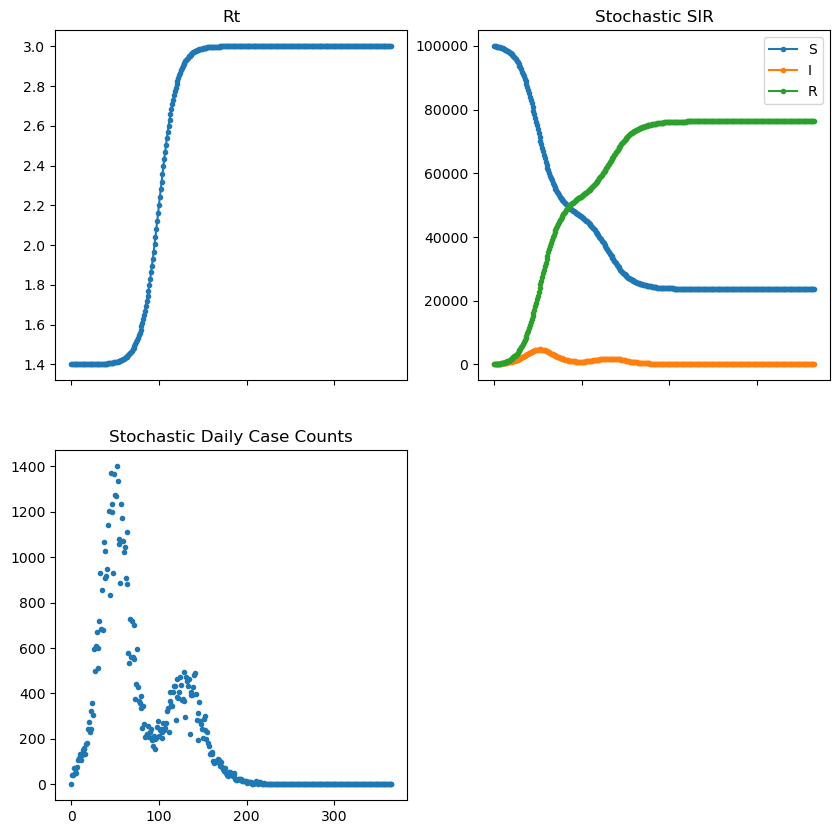

In [4]:
data.plot_all()

In [123]:
# simulate_data.simulate_data(rt_0, rt_1, midpoint, k, n_t, t_I, N, S_init, I_init, add_noise=False).plot_all(path=None)

## Model

In [27]:
import model
importlib.reload(model)

<module 'model' from 'C:\\Users\\hyone\\Documents\\GitHub\\rt-estimation\\src\\model.py'>

In [28]:
sir_model = SIR_model(data)

likelihood = {'distribution': 'students-t', 
              'nu': 4,
              'sigma': 0.2,
              'min_sigma': 10,
              }
prior = {'rt_0_a': 1.,
         'rt_0_b': 4.,
         'rt_1_a': 1.5,
         'rt_1_b': 4.,
         'k_a': 0.01,
         'k_b': 2,
         'm_a': 30,
         'm_b': 200,
         'I0_lambda': 50,
         }

method = 'NUTS'
n_samples = 10_000
n_tune = 1000

from datetime import date
import os
import os.path as path

today = date.today()
name = f'{method}_more_noise'

path = path.abspath(f'../data/{today}_{name}')
if not os.path.exists(path):
    os.makedirs(path)

In [29]:
logging.basicConfig(filename=f'{path}/example.log', encoding='utf-8', level=logging.DEBUG)
logging.info(f'true values rt_0: {rt_0}, rt_1: {rt_1}, midpoint: {midpoint}, k: {k}')
logging.info(f'fixed parameters t_I: {t_I}, N: {N}, S_init: {S_init}, I_init: {I_init}')

logging.info(f'likelihood: {likelihood}')
logging.info(f'prior parameters: {prior}')
logging.info(f'MCMC method: {method}')
logging.info(f'Number of draws: {n_samples} Burn in: {n_tune}')

In [ ]:
sir_model.run_SIR_model(n_samples=n_samples, n_tune=n_tune, likelihood=likelihood, prior=prior, method=method)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [rt_0, rt_1, k]
>CompoundStep
>>Metropolis: [midpoint]
>>Metropolis: [I0]


In [ ]:
gv = pm.model_to_graphviz(sir_model.model)
gv.render(filename=f'{path}/model',format='pdf')

In [ ]:
vars = ['rt_0', 'rt_1', 'k', 'midpoint', 'I0']

import pandas as pd

if method == "metropolis":
    acceptance_rate = sir_model.trace.sample_stats['accepted'].sum(axis=1).data / n_samples
    acceptance_rate = pd.DataFrame(acceptance_rate, columns=vars)
elif method == "NUTS":
    acceptance_rate = sir_model.trace.sample_stats['accepted'].sum(dim="draw").data / n_samples

logging.info(f'acceptance_rate:\n {acceptance_rate}')

In [ ]:
acceptance_rate

In [ ]:
summary_df = az.summary(sir_model.trace, var_names=vars).round(2)
summary_df['truth'] = [rt_0, rt_1, k, midpoint, I_init]
summary_df

logging.info(f'trace summary:\n {summary_df}')

In [ ]:
for var in vars:
    means = sir_model.trace.posterior[var].data.mean(axis=1)
    logging.info(f"posterior means by chain {var} {means} ")

### Make and Save Plots

In [ ]:
data.plot_all(path)

In [ ]:
lines = (
    ('rt_0',{}, rt_0),
    ('rt_1',{}, rt_1),
    ('k',{}, k),
    ('midpoint',{}, midpoint),
    ('I0',{}, I_init))
trace_plot = az.plot_trace(sir_model.trace, var_names=vars, lines=lines, figsize=(18,20))

In [ ]:
ref_val = {
    "rt_0": [{"ref_val" : rt_0}],
    "rt_1": [{"ref_val" : rt_1}],
    "k": [{"ref_val" : k}],
    "midpoint": [{"ref_val" : midpoint}],
    "I0": [{"ref_val" : I_init}],}
post_plot = az.plot_posterior(sir_model.trace, var_names=vars, ref_val=ref_val, ref_val_color='red', figsize=(20,5))

In [ ]:
sir_model.trace.extend(sir_model.prior)
prior_post_plot = az.plot_dist_comparison(sir_model.trace, var_names=vars)

In [ ]:
def flat_t(var):
    x = sir_model.trace.posterior[var].data
    x = x.reshape((x.shape[0], np.prod(x.shape[1:], dtype=int)))
    return x.mean(axis=0).flatten()

cov_matrix = np.cov(np.stack(list(map(flat_t, vars))))

import seaborn as sns
cov_plot = sns.heatmap(cov_matrix, annot=True, xticklabels=vars, yticklabels=vars)

In [ ]:
corr = np.corrcoef(np.stack(list(map(flat_t, vars))))
corr_plot = sns.heatmap(corr, annot=True, xticklabels=vars, yticklabels=vars)

In [ ]:
corr

In [ ]:
fig_parallel = az.plot_parallel(sir_model.trace, var_names=vars, norm_method="normal")

In [25]:
# az.plot_parallel(sir_model.trace, var_names=vars, norm_method="normal")

# _posterior = sir_model.trace.posterior[vars].mean(dim="chain").to_array().data

# fig_parallel, axs = plt.subplots(2, figsize=(10,10))

# axs[0].plot(_posterior[:], color='black', alpha=0.1)

# axs[0].tick_params(labelsize=10)
# axs[0].set_xticks(range(len(vars)))
# axs[0].set_xticklabels(vars)

# # normalize
# mean = np.mean(_posterior, axis=1)
# standard_deviation = np.std(_posterior, axis=1)
# for i in range(0, np.shape(mean)[0]):
#     _posterior[i, :] = (_posterior[i, :] - mean[i]) / standard_deviation[i]

# axs[1].plot(_posterior[:], color='black', alpha=0.1)

# axs[1].tick_params(labelsize=10)
# axs[1].set_xticks(range(len(vars)))
# axs[1].set_xticklabels(vars)


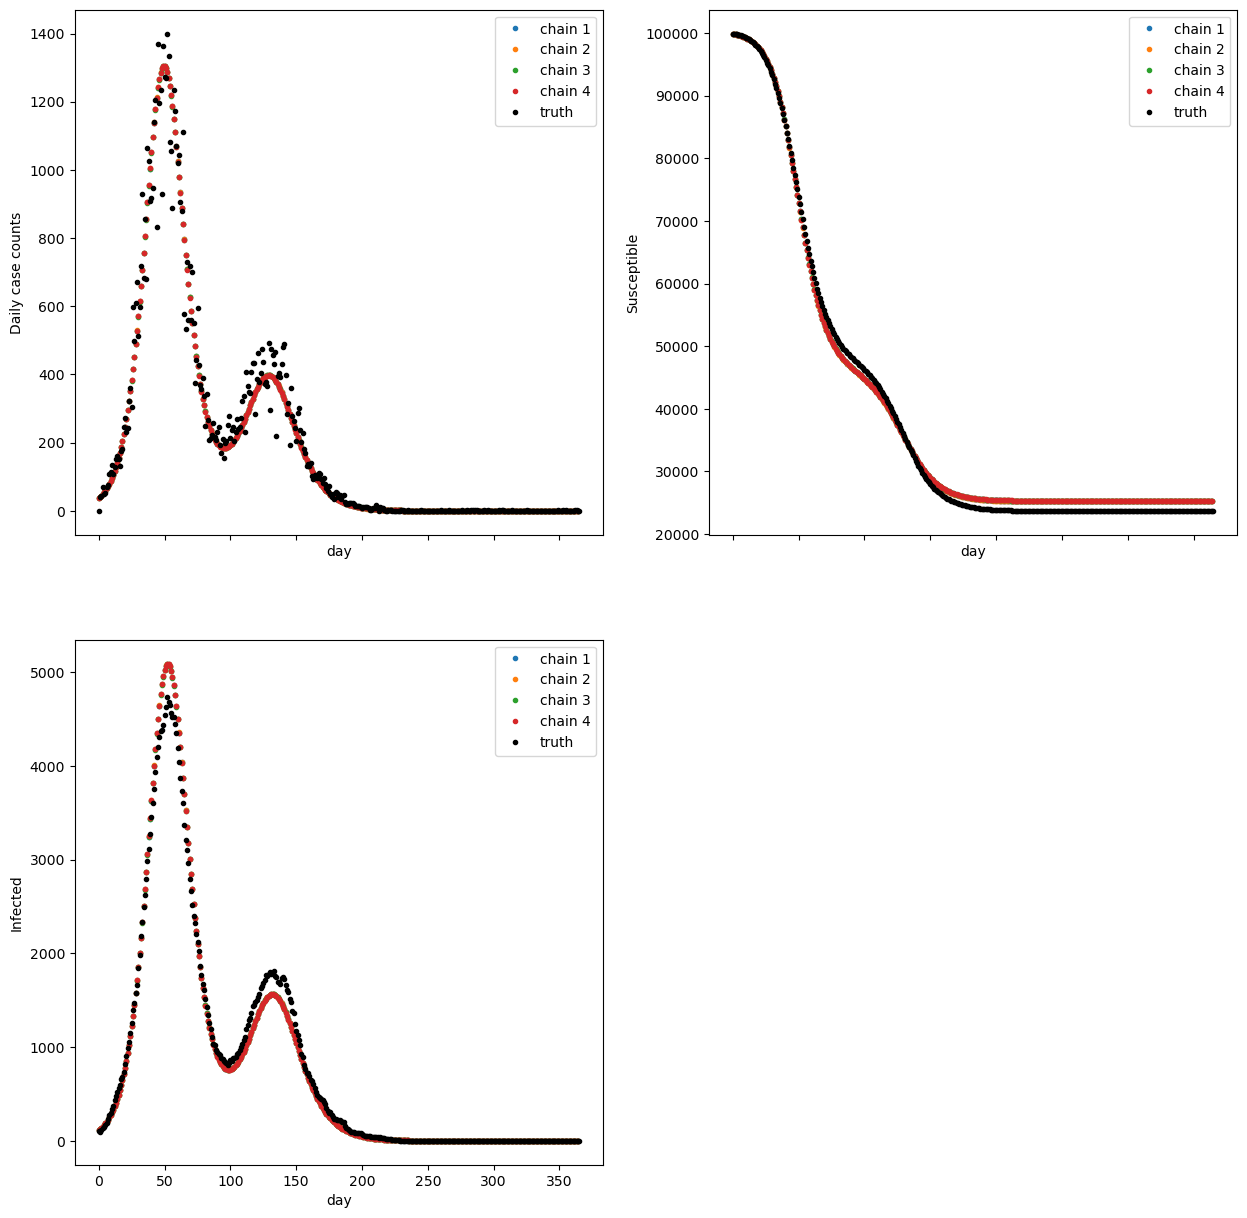

In [22]:
fig_sir, ax = plt.subplots(2, 2, sharex= True, figsize=(15,15))

for x in range(4):
    ax[0,0].plot(sir_model.trace.posterior["i"].data.mean(axis=1)[x], '.', label=f'chain {x+1}')
ax[0,0].plot(data.i, '.', label="truth", color='black')
ax[0,0].set_xlabel('day')
ax[0,0].set_ylabel('Daily case counts')
ax[0,0].legend()

for x in range(4):
    ax[0,1].plot(sir_model.trace.posterior["S"].data.mean(axis=1)[x], '.', label=f'chain {x+1}')
ax[0,1].plot(data.S, '.', label="truth", color='black')
ax[0,1].set_xlabel('day')
ax[0,1].set_ylabel('Susceptible')
ax[0,1].legend()

for x in range(4):
    ax[1,0].plot(sir_model.trace.posterior["I"].data.mean(axis=1)[x], '.', label=f'chain {x+1}')
ax[1,0].plot(data.I, '.', label="truth", color='black')
ax[1,0].set_xlabel('day')
ax[1,0].set_ylabel('Infected')
ax[1,0].legend()

fig_sir.delaxes(ax[1,1])

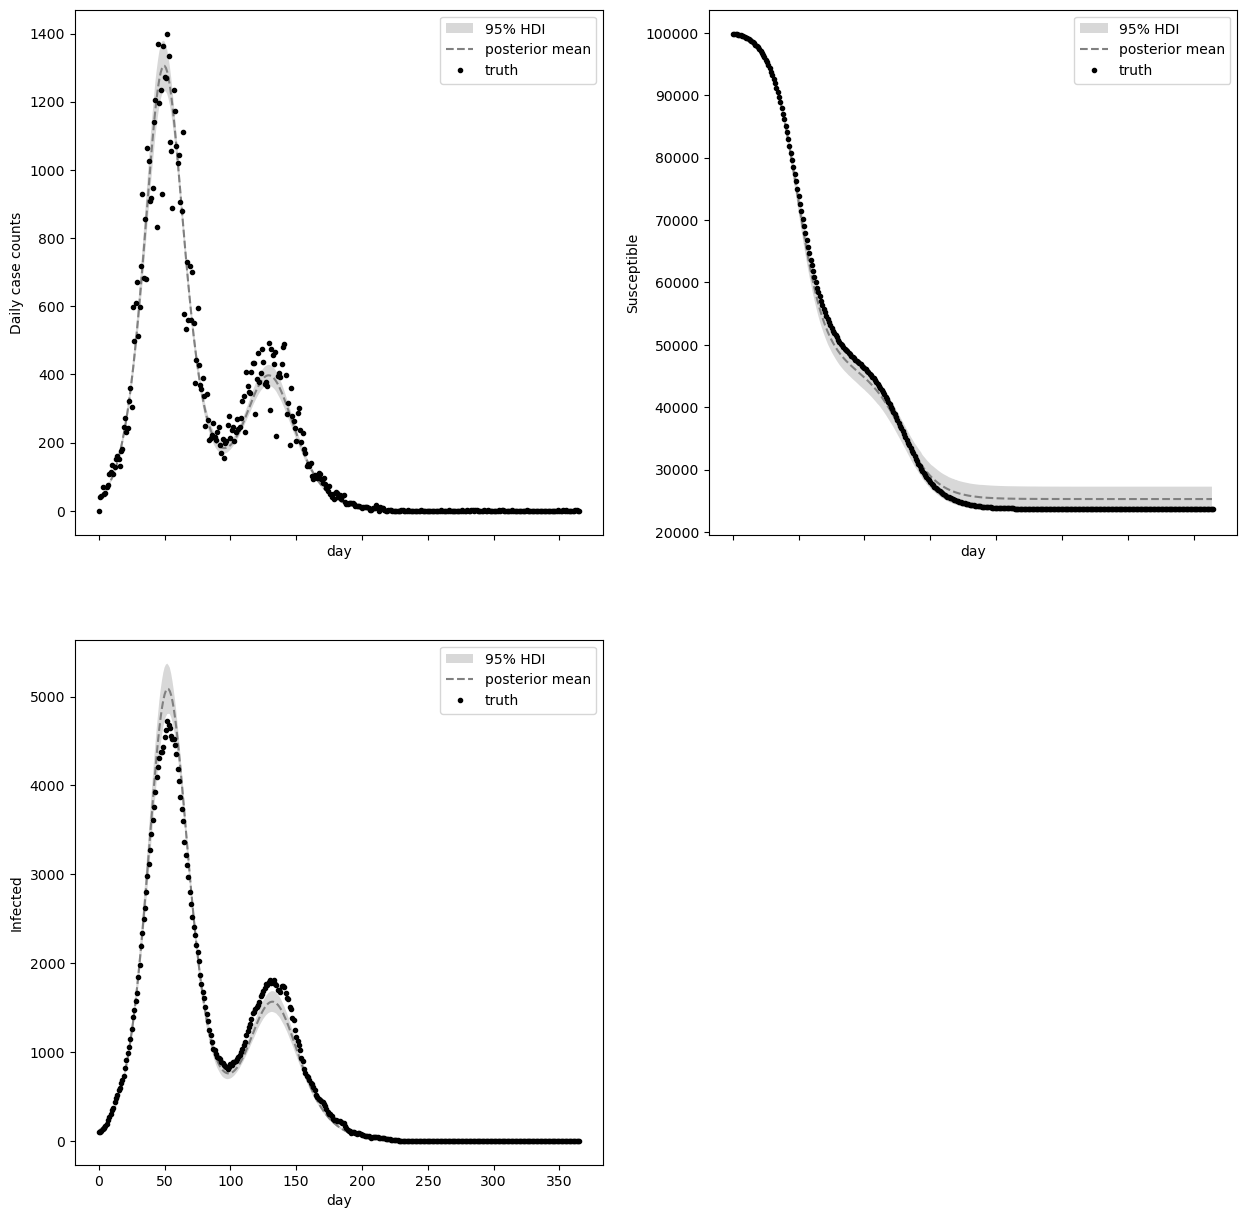

In [23]:
fig_sir_ci, ax = plt.subplots(2, 2, sharex= True, figsize=(15,15))

i_ci = az.hdi(sir_model.trace, var_names=["i"], hdi_prob = 0.95).to_array().squeeze().data
i_mean = sir_model.trace.posterior['i'].mean(dim=["chain","draw"]).data
ax[0,0].fill_between(range(n_t), i_ci[:,0], i_ci[:,1], facecolor='gray', alpha=0.3, label='95% HDI')
ax[0,0].plot(i_mean, '--', label="posterior mean", color='gray')
ax[0,0].plot(data.i, '.', label="truth", color='black')
ax[0,0].set_xlabel('day')
ax[0,0].set_ylabel('Daily case counts')
ax[0,0].legend()

S_ci = az.hdi(sir_model.trace, var_names=["S"], hdi_prob = 0.95).to_array().squeeze().data
S_mean = sir_model.trace.posterior['S'].mean(dim=["chain","draw"]).data
ax[0,1].fill_between(range(n_t), S_ci[:,0], S_ci[:,1], facecolor='gray', alpha=0.3, label='95% HDI')
ax[0,1].plot(S_mean, '--', label="posterior mean", color='gray')
ax[0,1].plot(data.S, '.', label="truth", color='black')
ax[0,1].set_xlabel('day')
ax[0,1].set_ylabel('Susceptible')
ax[0,1].legend()

I_ci = az.hdi(sir_model.trace, var_names=["I"], hdi_prob = 0.95).to_array().squeeze().data
I_mean = sir_model.trace.posterior['I'].mean(dim=["chain","draw"]).data
ax[1,0].fill_between(range(n_t), I_ci[:,0], I_ci[:,1], facecolor='gray', alpha=0.3, label='95% HDI')
ax[1,0].plot(I_mean, '--', label="posterior mean", color='gray')
ax[1,0].plot(data.I, '.', label="truth", color='black')
ax[1,0].set_xlabel('day')
ax[1,0].set_ylabel('Infected')
ax[1,0].legend()

fig_sir_ci.delaxes(ax[1,1])

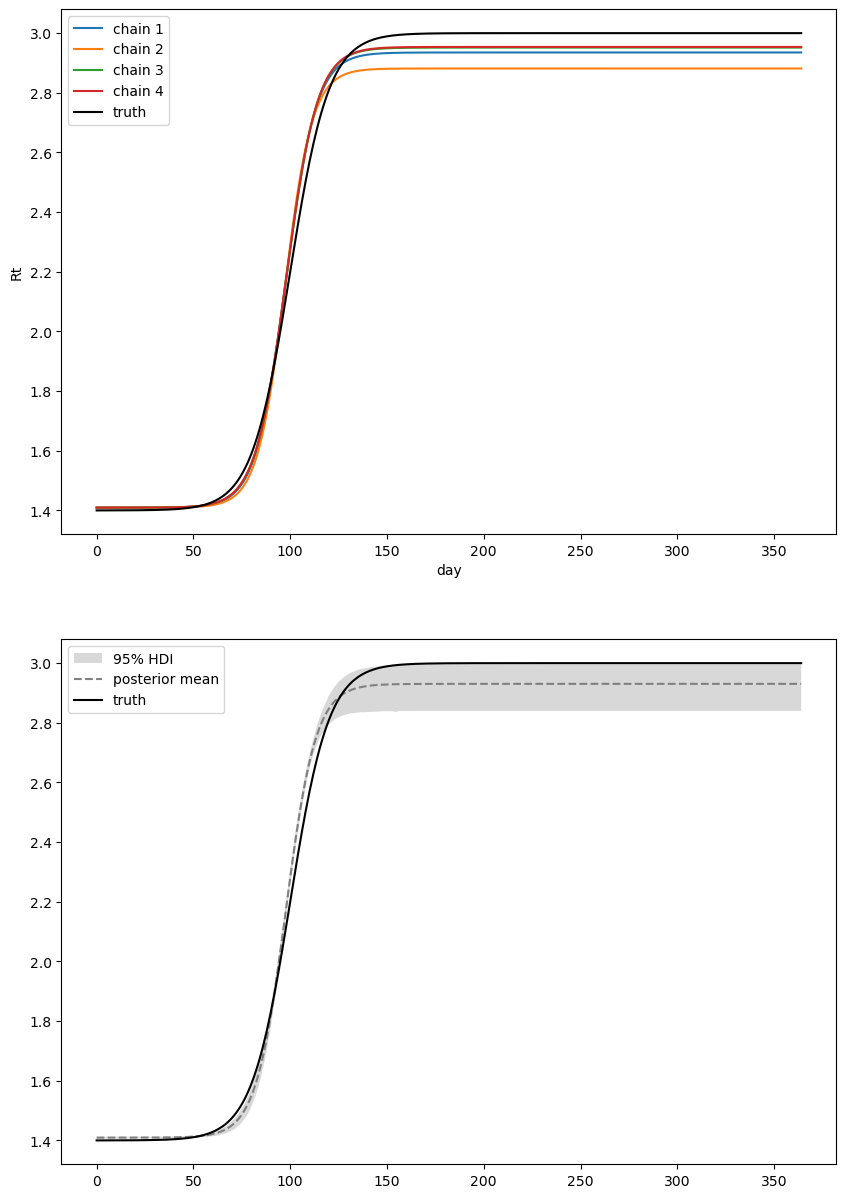

In [22]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig_Rt, ax = plt.subplots(2, figsize=(10,15))

for x in range(4):
    ax[0].plot(sir_model.trace.posterior["Rt"].data.mean(axis=1)[x], label=f"chain {x+1}", color = colors[x])
    
ax[0].plot(data.rt, label = "truth", color='black')
ax[0].set_xlabel('day')
ax[0].set_ylabel('Rt')
ax[0].legend()

rt_ci = az.hdi(sir_model.trace, var_names="Rt", hdi_prob = 0.95).to_array().squeeze().data
mean = sir_model.trace.posterior['Rt'].mean(dim=["chain","draw"]).data

ax[1].fill_between(range(n_t), rt_ci[:,0], rt_ci[:,1], facecolor='gray', alpha=0.3, label='95% HDI')
ax[1].plot(mean, '--', label = "posterior mean", color = 'gray')
ax[1].plot(data.rt, label = "truth", color='black')
ax[1].legend()

# for x in range(4):
#     ax.plot(sir_model.trace.posterior["Rt"].data.mean(axis=1)[x], label=f"chain {x+1}", color=colors[x])
#     ax.plot(sir_model.trace.posterior["Rt"].quantile(q=.025, dim=['draw']).data[x], color=colors[x], alpha=0.25)
#     ax.plot(sir_model.trace.posterior["Rt"].quantile(q=.975, dim=['draw']).data[x], color=colors[x], alpha=0.25)
    
# plt.plot(data.rt, label = "truth", color='black')
# plt.legend()

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages(f'{path}/{name}_mcmc_plots.pdf') as pdf:
    pdf.savefig(trace_plot.ravel()[0].figure)
    pdf.savefig(post_plot.ravel()[0].figure)
    pdf.savefig(prior_post_plot.ravel()[0].figure)
    pdf.savefig(cov_plot.figure)
    pdf.savefig(corr_plot.figure)
    pdf.savefig(fig_parallel)
    pdf.savefig(fig_sir)
    pdf.savefig(fig_sir_ci)
    pdf.savefig(fig_Rt)

### Save Trace and Model

In [ ]:
data.save_data(path)

In [ ]:
sir_model.trace.to_netcdf(f"{path}/trace.nc")

'C:\\Users\\hyone\\Documents\\GitHub\\rt-estimation\\data\\2023-01-20_metropolis_more_noise/trace.nc'

In [ ]:
# rt_post = sir_model.trace.posterior["Rt"].mean(dim='chain').data
# ax = sns.violinplot(rt_post)
# plt.show()

# rt_post = sir_model.trace.posterior["Rt"].mean(dim='chain').data
# ax = sns.violinplot(rt_post[:,::10])
# plt.show()


## Archive

In [26]:
class SIR_model():
    
    def __init__(self, data) :
        self.data = data
        self.setup_SIR_model()

    def setup_SIR_model(self):
        self.n_t = np.arange(0,len(self.data.i),1)
        self.I0 = pm.floatX(self.data.I[0])
        self.S0 = pm.floatX(self.data.N - self.I0)
        self.i = self.data.i[1:]
 
    def run_SIR_model(self, n_samples, n_tune, likelihood, prior, method):
        global t_I

        self.likelihood = likelihood
        self.n_samples = n_samples
        self.n_tune = n_tune
        self.likelihood = likelihood
        self.prior = prior
 
        with pm.Model() as model:
            rt_0 = pm.Uniform("rt_0", self.prior['rt_0_a'], self.prior['rt_0_b'])
            # rt_0 = 1.4
            rt_1 = pm.Uniform("rt_1", self.prior['rt_1_a'], self.prior['rt_1_b'])
            k = pm.Uniform("k", self.prior['k_a'], self.prior['k_b'])
            midpoint = pm.DiscreteUniform("midpoint", self.prior['m_a'], self.prior['m_b'])
            
            I0 = pm.Poisson("I0", self.prior["I0_lambda"])
            S0 = pm.Deterministic("S0", N - I0)            

            t = np.arange(n_t)

            Rt = pm.Deterministic("Rt", rt_0 + (rt_1 - rt_0) / (1. + np.exp(-k*(t - midpoint))))
            beta_t = pm.Deterministic("beta_t", Rt / t_I)

            def next_day(beta_t, S_t, I_t, _, t_I, N, dt=1):
                dSI = (beta_t * I_t * S_t / N) * dt
                dIR = (I_t / t_I) * dt
                S_t = S_t - dSI
                I_t = I_t + dSI - dIR
                S_t = pt.clip(S_t, 0., N)
                I_t = pt.clip(I_t, 0., N)

                return S_t, I_t, dSI
            
            new_I_0 = pt.zeros_like(self.I0, dtype="float64")
            
            results, _ = scan(
                fn=next_day,
                sequences=[beta_t],
                outputs_info=[S0, pm.floatX(I0), new_I_0],
                non_sequences=[data.t_I, data.N],
                n_steps=data.n_t
            )

            S, I, i = results
            pm.Deterministic("S", S)
            pm.Deterministic("I", I)
            pm.Deterministic("i", i)
            # print(model.point_logps())
            
            i_est = pm.StudentT("i_est",
                                nu=likelihood['nu'],
                                mu=i,
                                sigma=np.maximum(likelihood['min_sigma'], likelihood['sigma']*self.i),
                                observed=self.i
                               )
            if method == 'metropolis':
                step = pm.Metropolis()
            elif method == 'NUTS':
                step = pm.NUTS()
            else:
                raise Exception("Method must be either 'metropolis' or 'NUTS'")
            trace = pm.sample(n_samples, tune=n_tune, chains=4, cores=4, step=step)
        
        
        with model:
            pm.compute_log_likelihood(trace)
            prior_checks = pm.sample_prior_predictive(n_samples)
        
        self.model = model
        self.trace = trace
        self.prior = prior_checks

### Change point detection

rbf
0


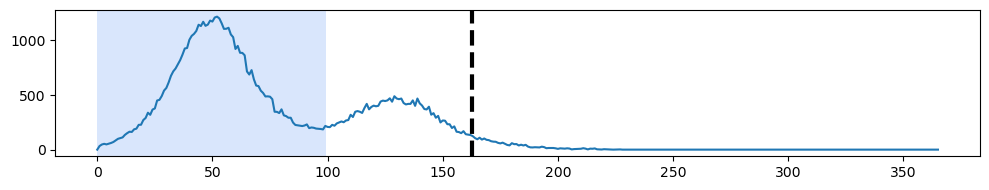

linear
0


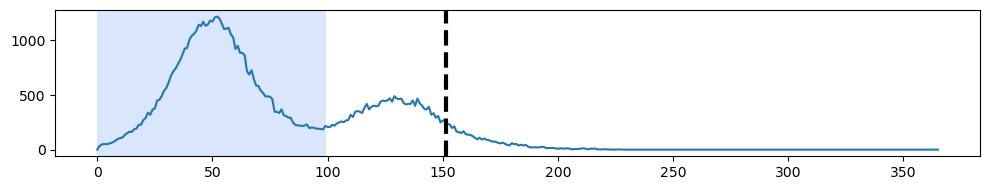

cosine
0


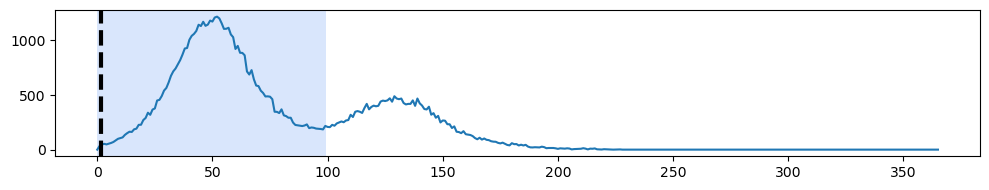

rbf
1


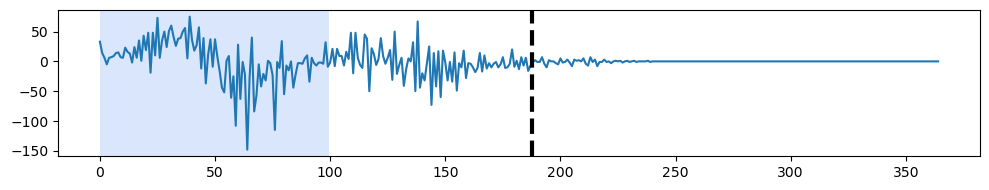

linear
1


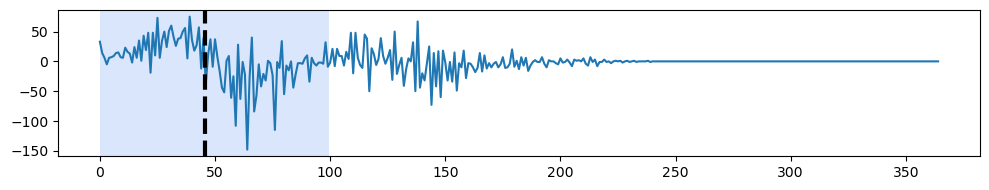

cosine
1


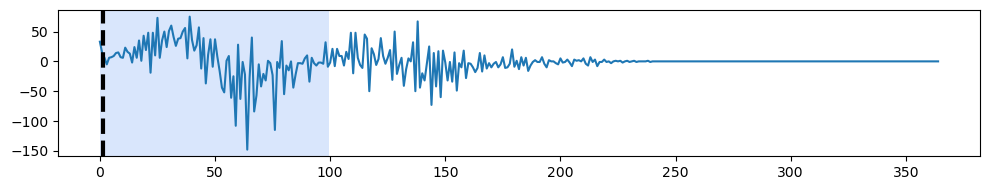

rbf
2


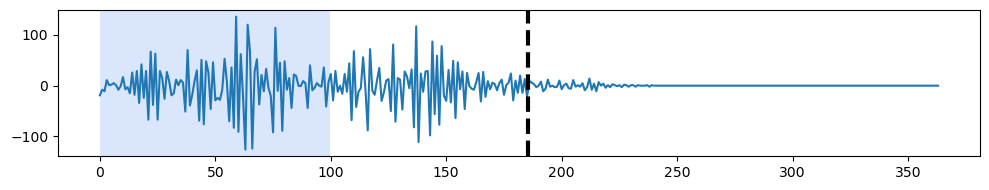

linear
2


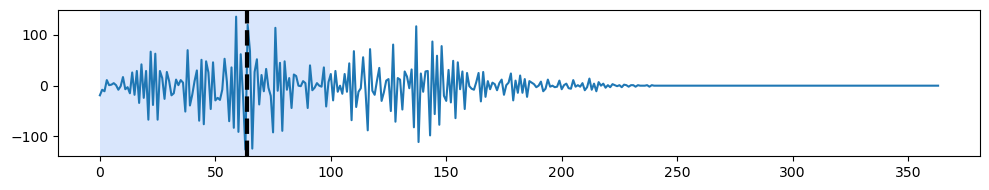

cosine
2


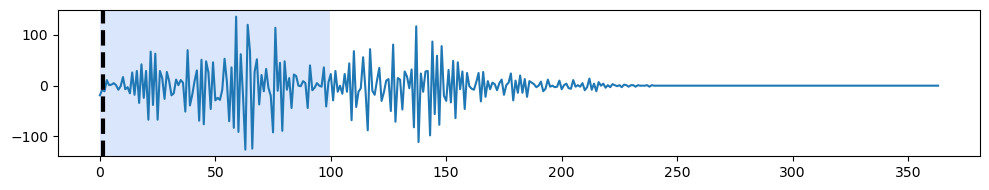

rbf
3


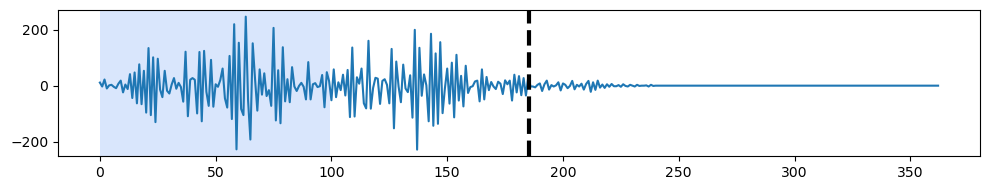

linear
3


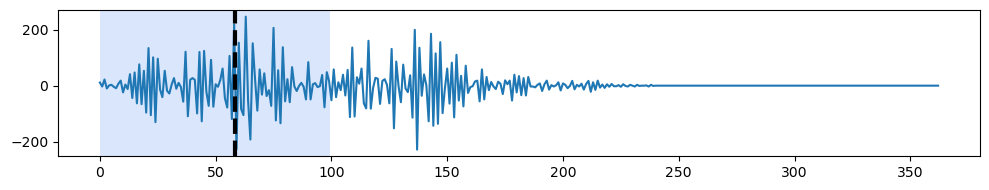

cosine
3


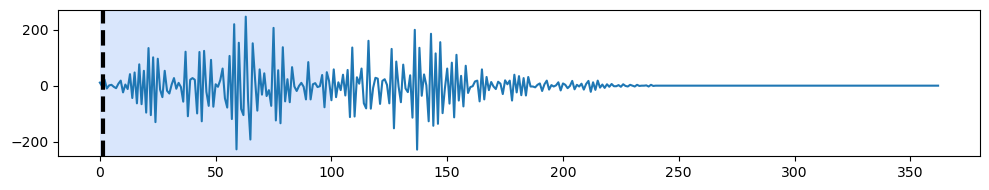

rbf
4


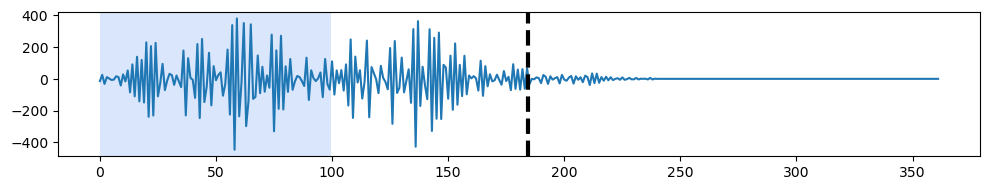

linear
4


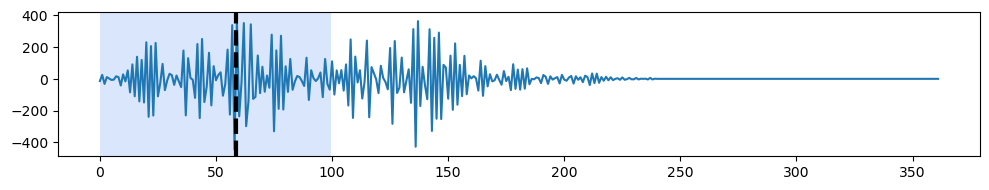

cosine
4


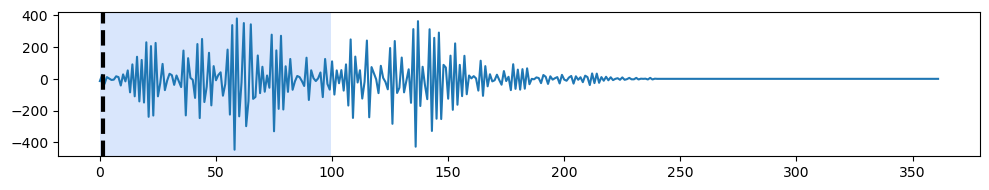

In [262]:
import ruptures as rpt

bkps = [midpoint]

kernels = ["rbf", "linear", "cosine"]

for n in range(5):
    for k in kernels:
        print(k)
        print(n)
        algo = rpt.KernelCPD(kernel=k).fit(np.array(np.diff(data.i, n=n)))
        result = algo.predict(n_bkps=1)

        # display
        rpt.display(np.array(np.diff(data.i, n=n)), bkps, result)
        plt.show()

l1
0


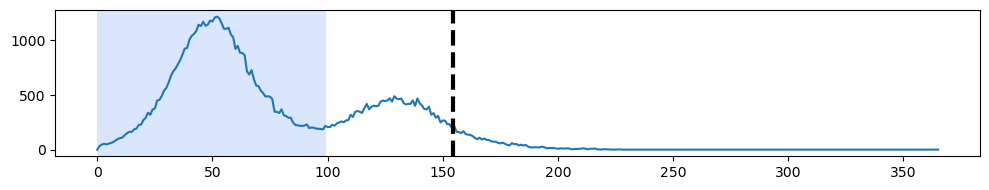

l2
0


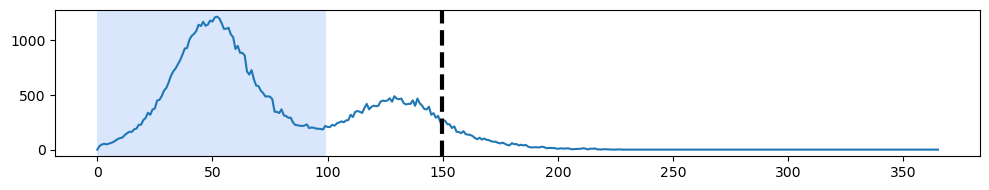

rbf
0


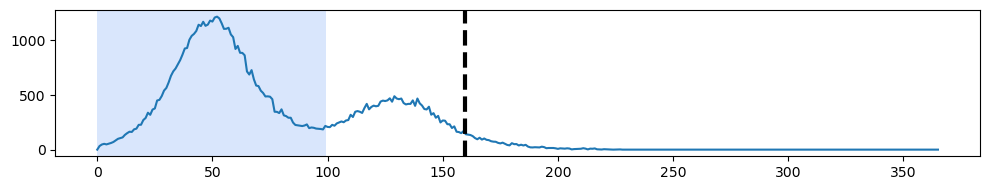

l1
1


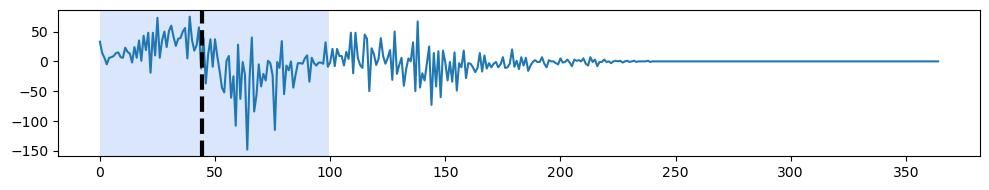

l2
1


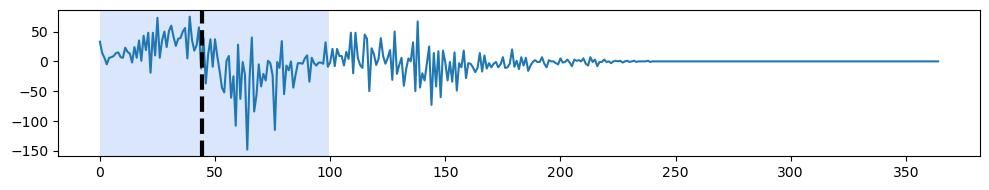

rbf
1


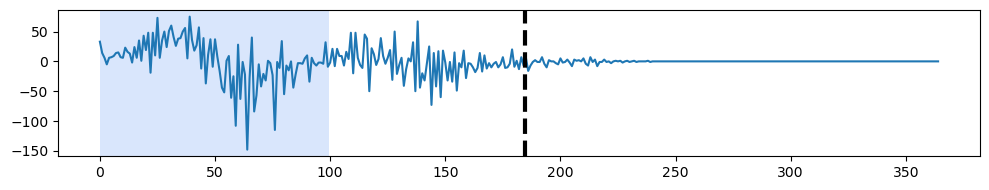

l1
2


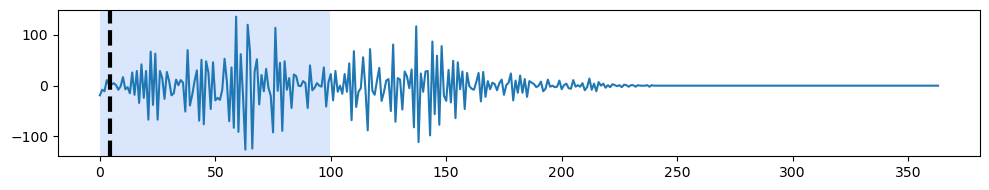

l2
2


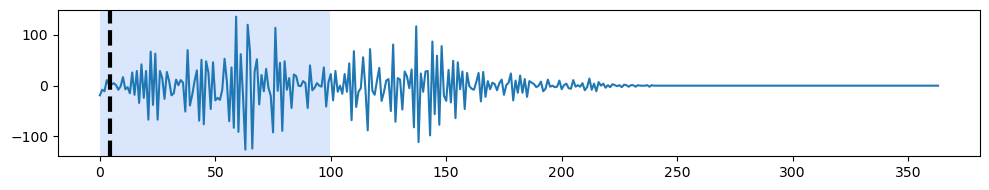

rbf
2


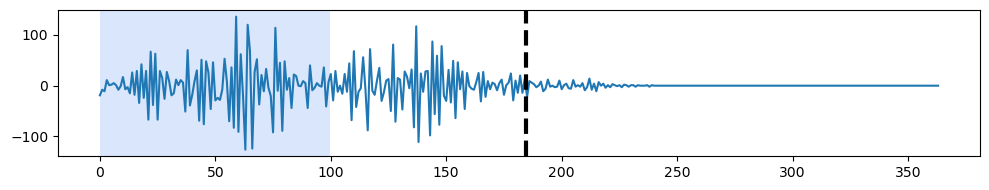

l1
3


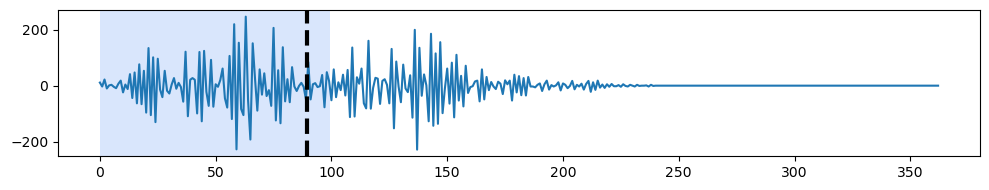

l2
3


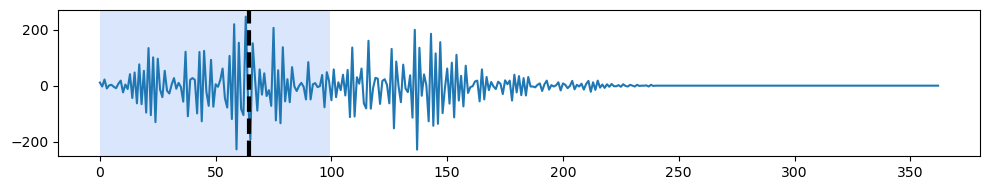

rbf
3


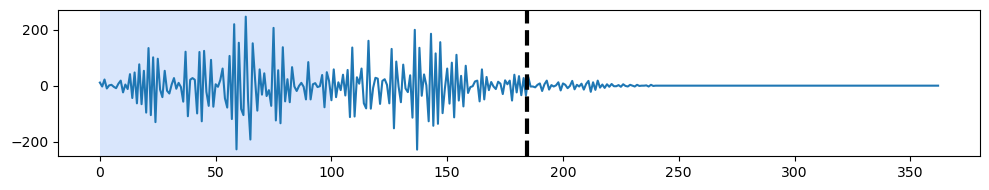

l1
4


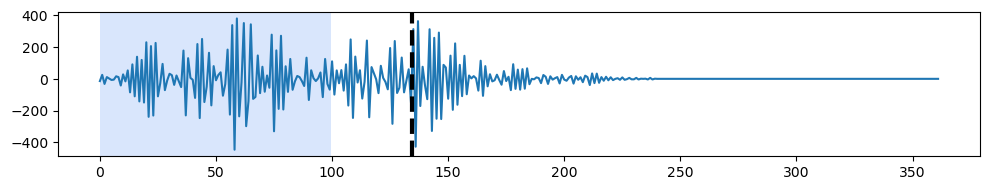

l2
4


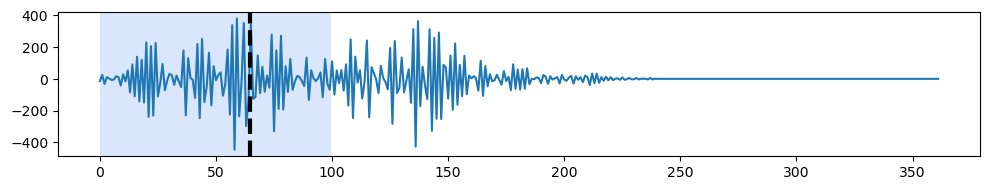

rbf
4


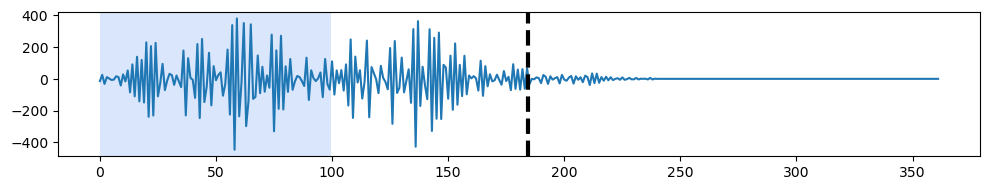

In [263]:
models = ["l1", "l2", "rbf"]

for n in range(5):
    for m in models:
        print(m)
        print(n)
        algo = rpt.Dynp(model=m).fit(np.array(np.diff(data.i, n=n)))
        result = algo.predict(n_bkps=1)

        # display
        rpt.display(np.array(np.diff(data.i, n=n)), bkps, result)
        plt.show()

l1
0


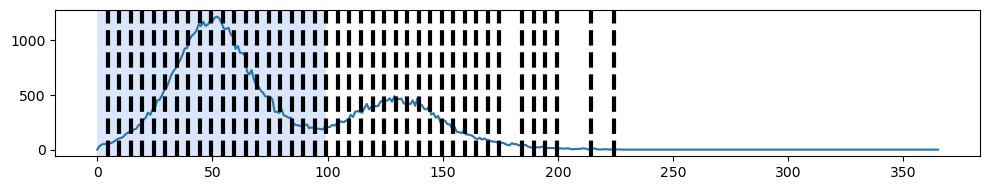

l2
0


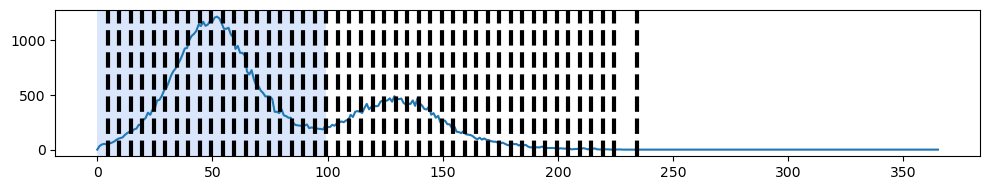

rbf
0


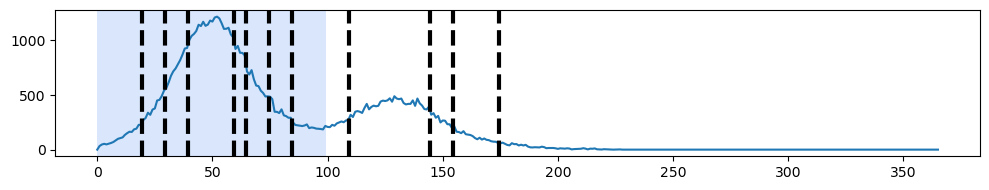

l1
1


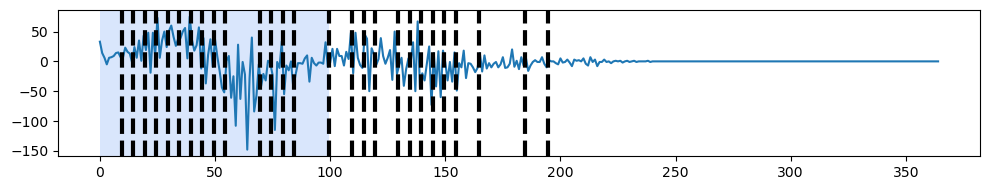

l2
1


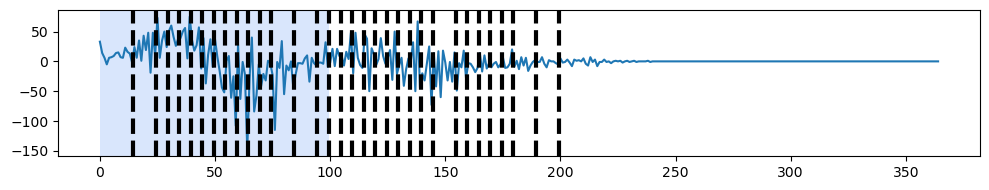

rbf
1


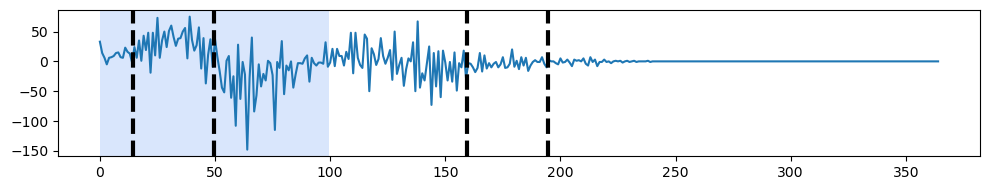

l1
2


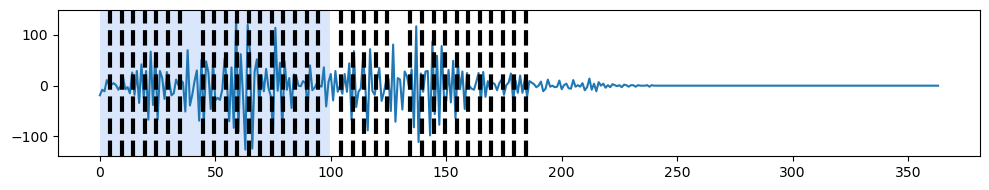

l2
2


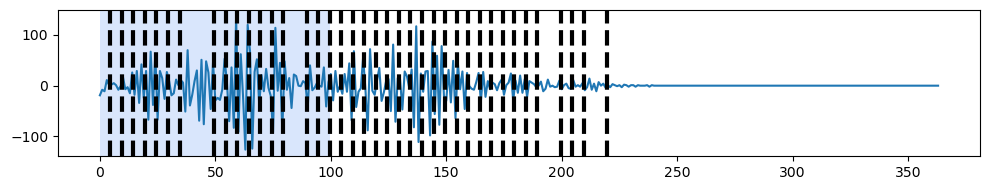

rbf
2


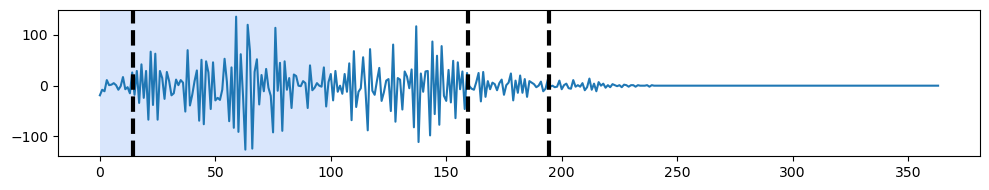

l1
3


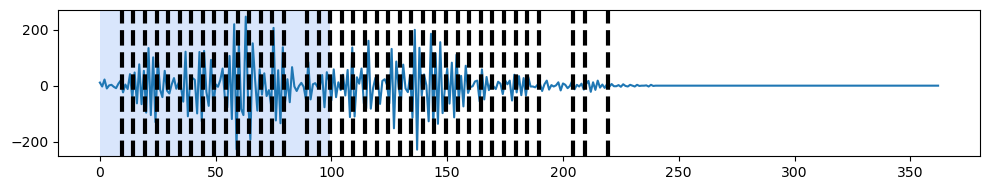

l2
3


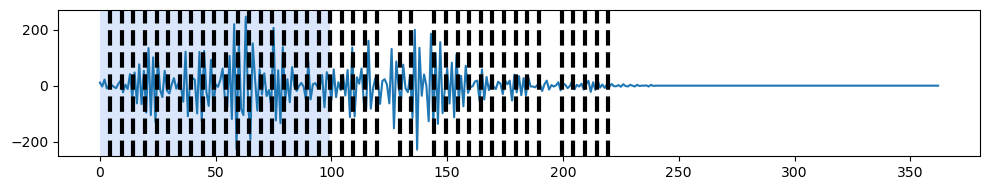

rbf
3


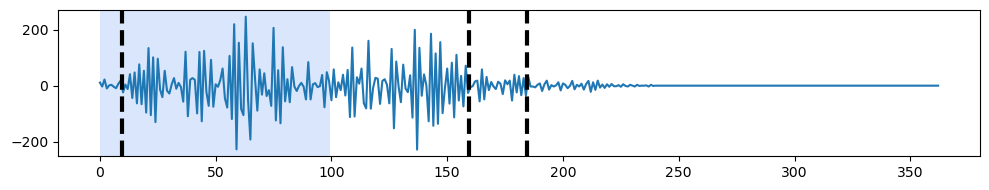

l1
4


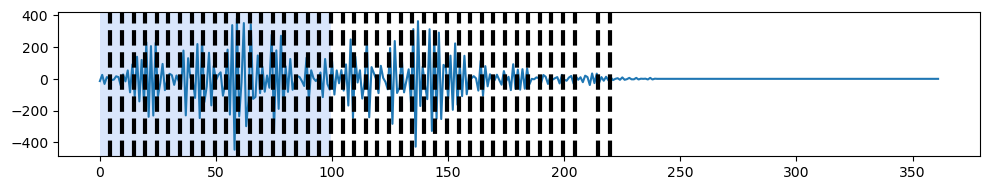

l2
4


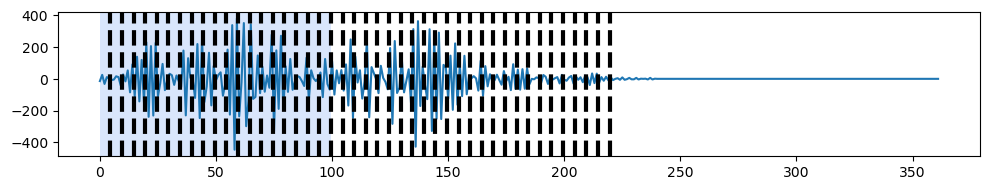

rbf
4


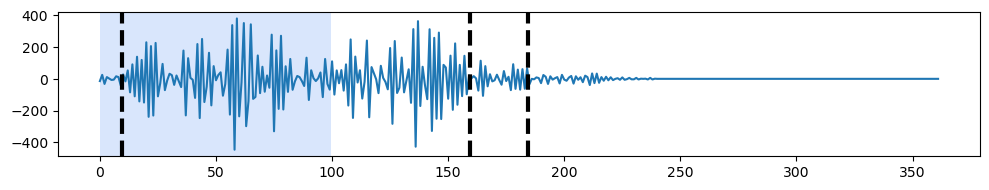

In [264]:
models = ["l1", "l2", "rbf"]

for n in range(5):
    for m in models:
        print(m)
        print(n)
        algo = rpt.Pelt(model=m).fit(np.array(np.diff(data.i, n=n)))
        result = algo.predict(pen=3)

        # display
        rpt.display(np.array(np.diff(data.i, n=n)), bkps, result)
        plt.show()

l2
0


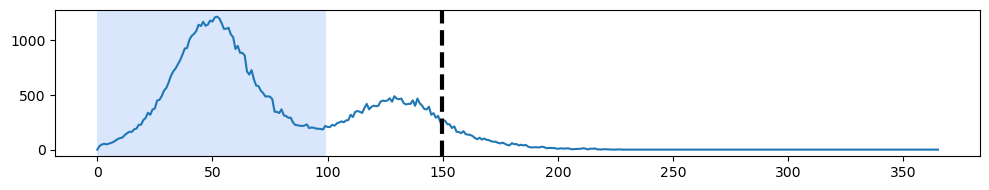

l1
0


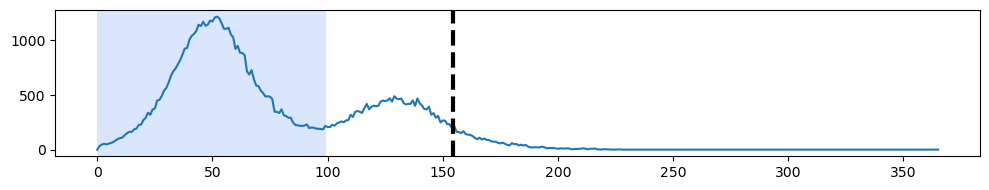

rbf
0


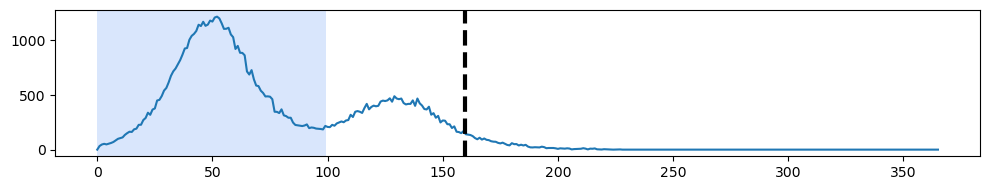

normal
0


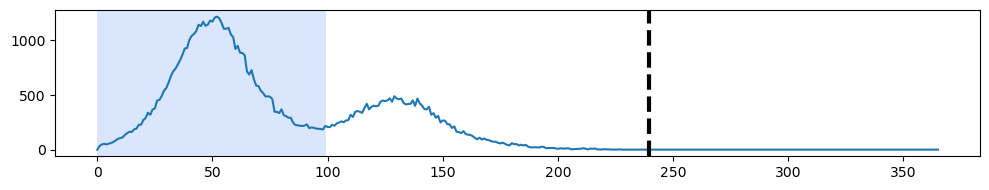

ar
0


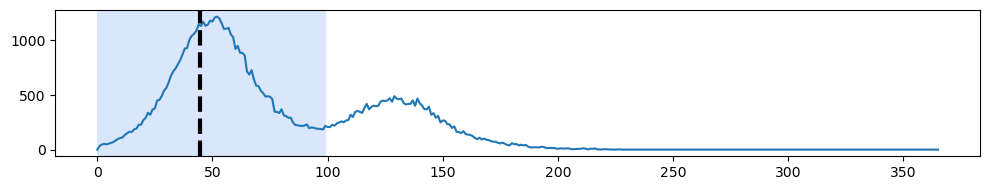

l2
1


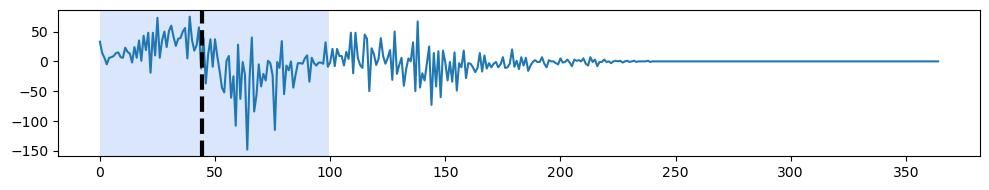

l1
1


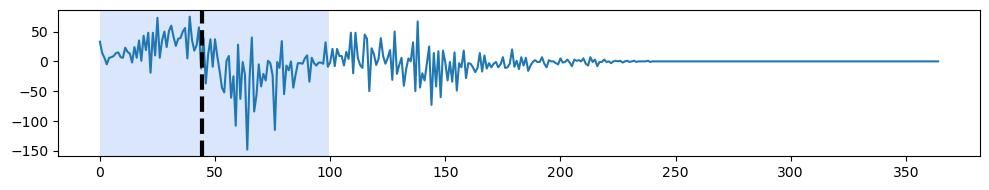

rbf
1


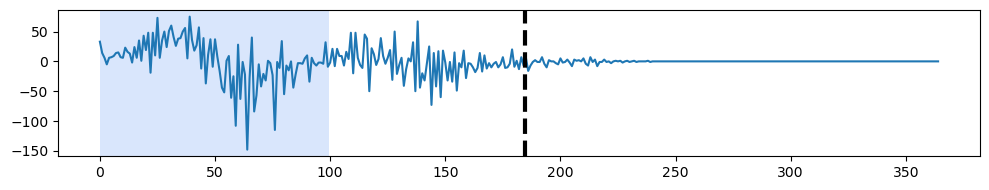

normal
1


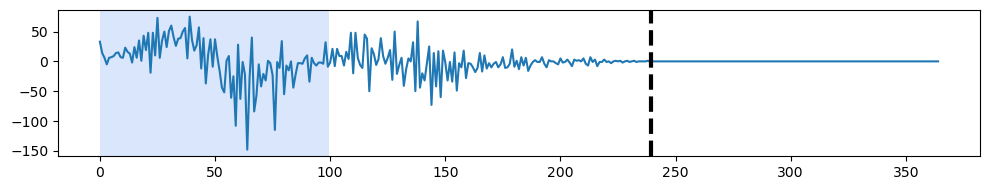

ar
1


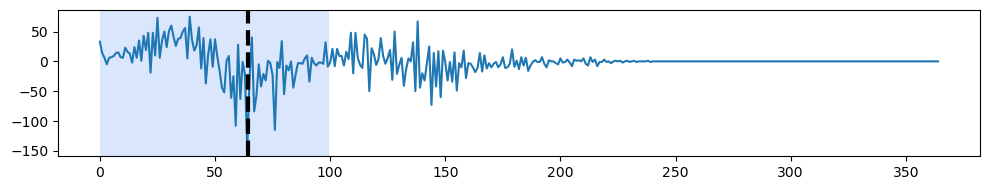

l2
2


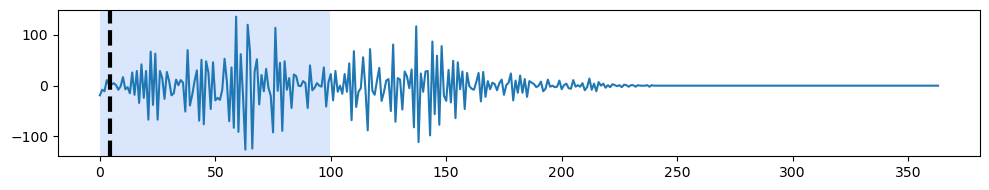

l1
2


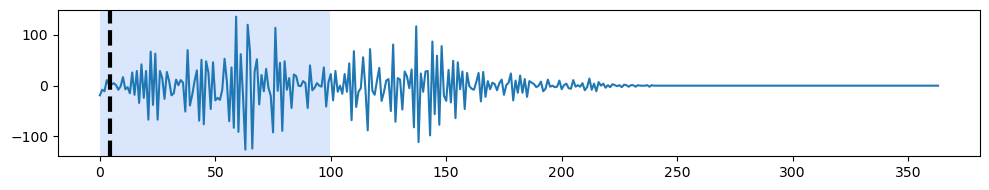

rbf
2


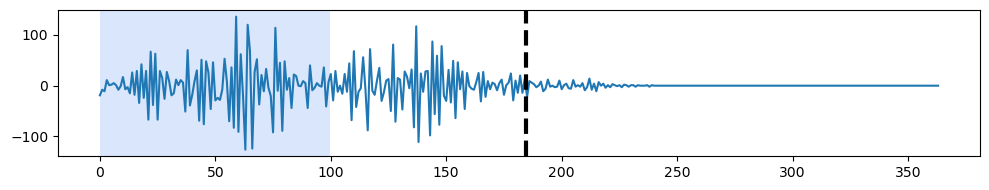

normal
2


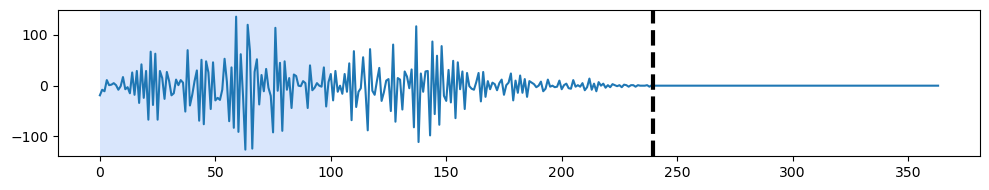

ar
2


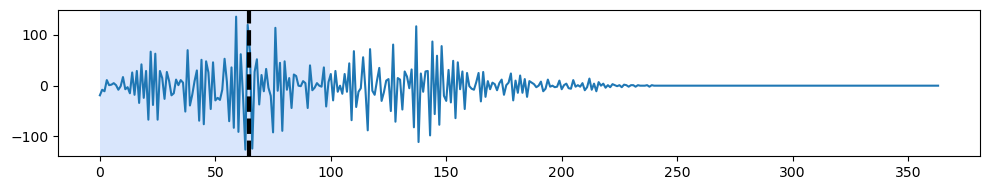

l2
3


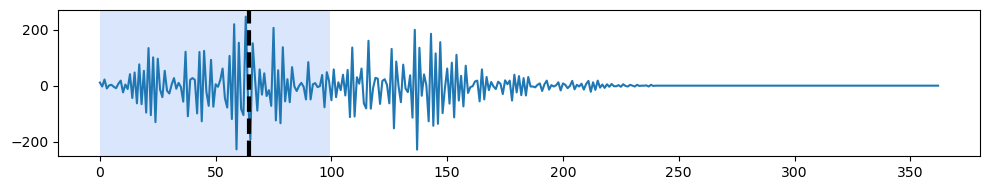

l1
3


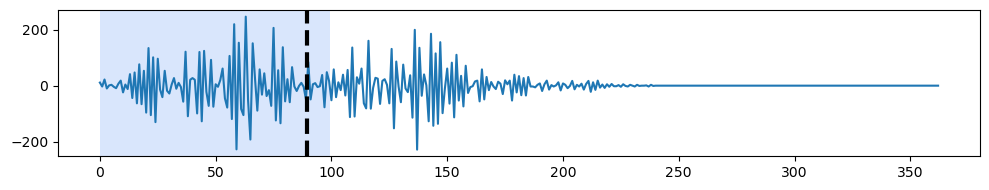

rbf
3


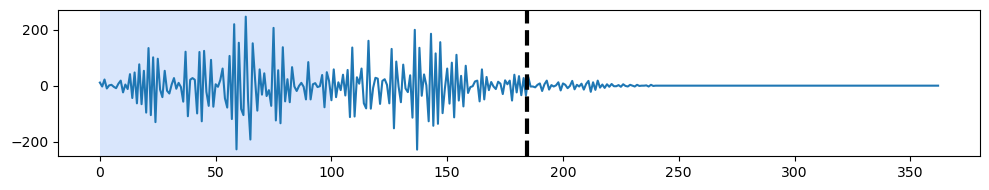

normal
3


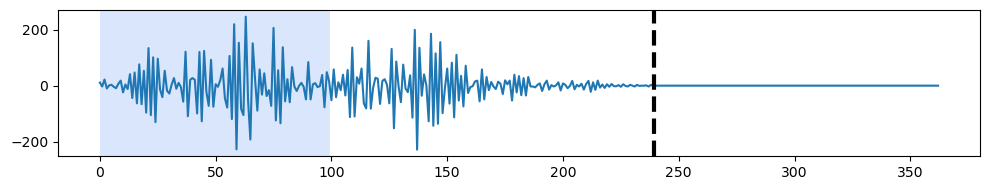

ar
3


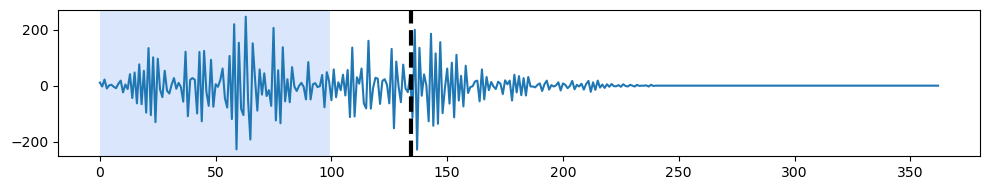

l2
4


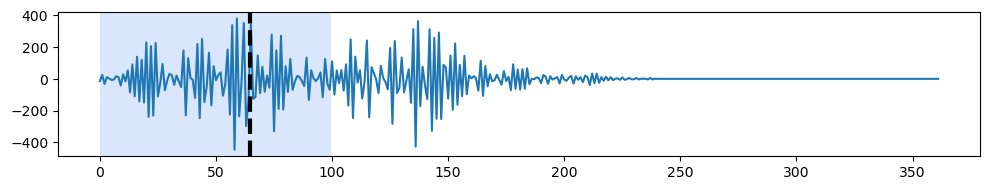

l1
4


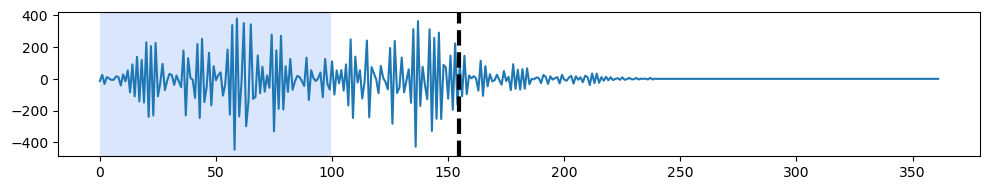

rbf
4


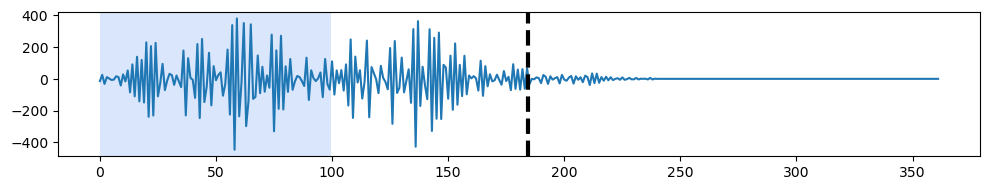

normal
4


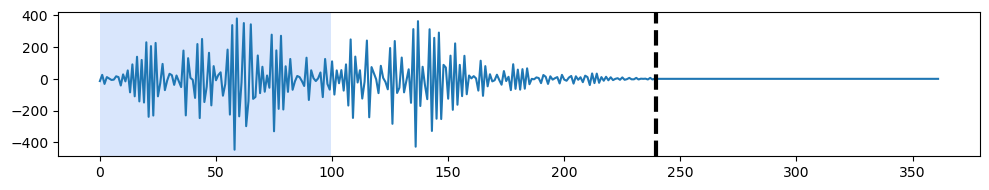

ar
4


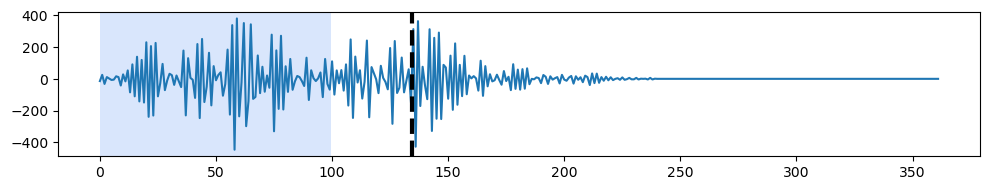

In [265]:
models = ["l2", "l1", "rbf", "normal", "ar"]

for n in range(5):
    for m in models:
        print(m)
        print(n)
        algo = rpt.Binseg(model=m).fit(np.array(np.diff(data.i, n=n)))
        result = algo.predict(n_bkps=1)

        # display
        rpt.display(np.array(np.diff(data.i, n=n)), bkps, result)
        plt.show()

l2
0


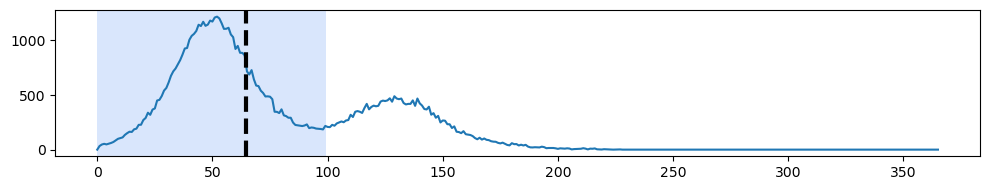

l1
0


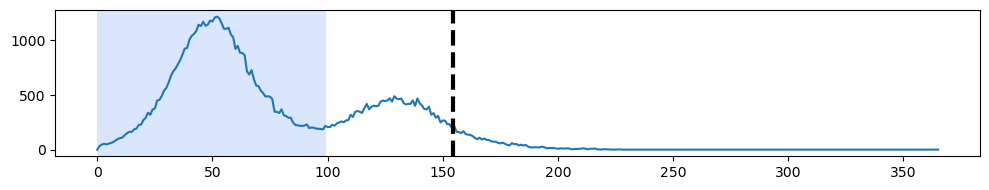

rbf
0


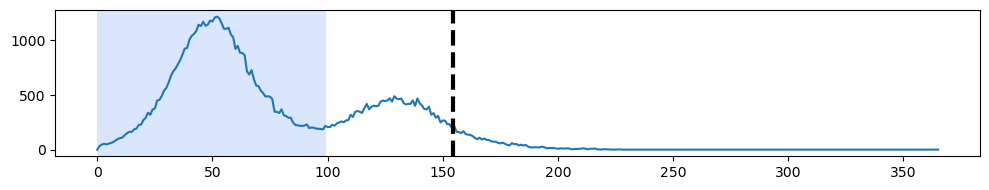

normal
0


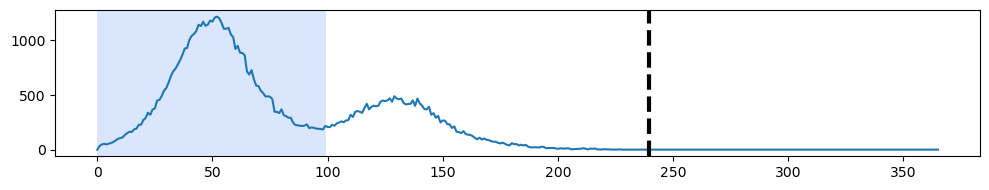

ar
0


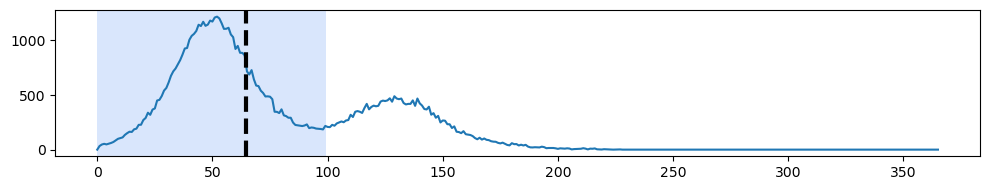

l2
1


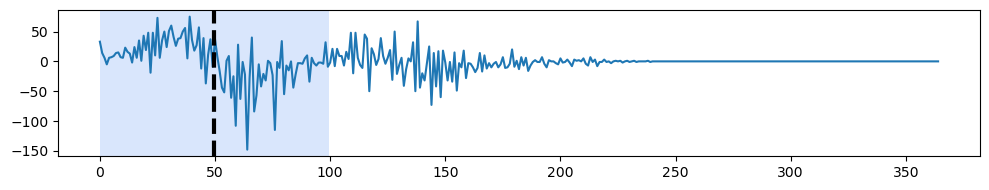

l1
1


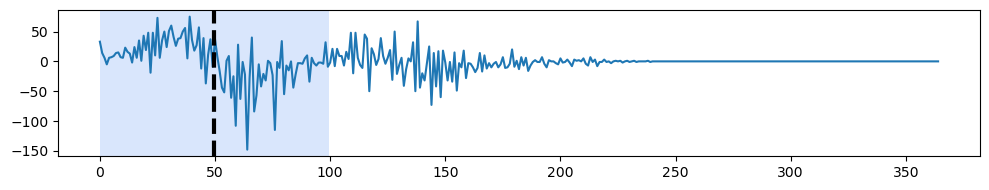

rbf
1


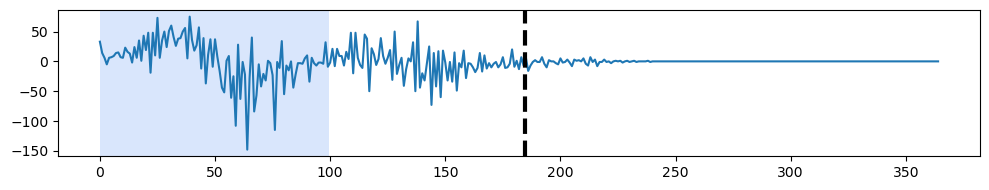

normal
1


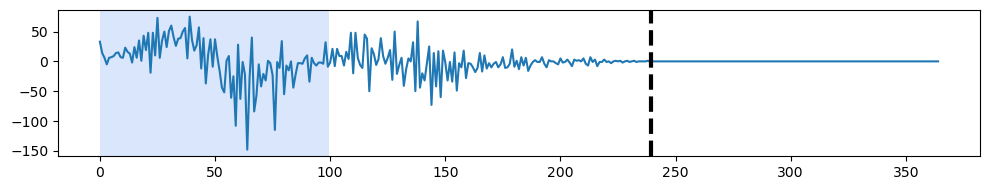

ar
1


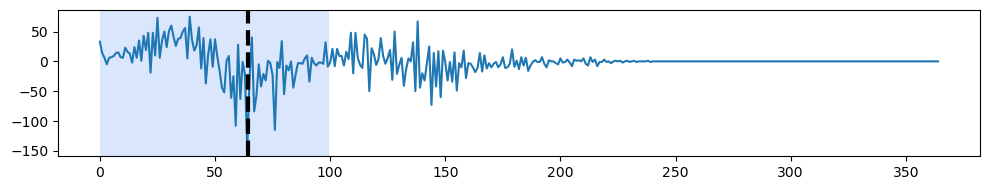

l2
2


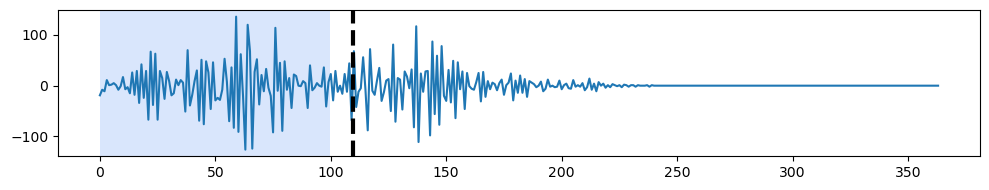

l1
2


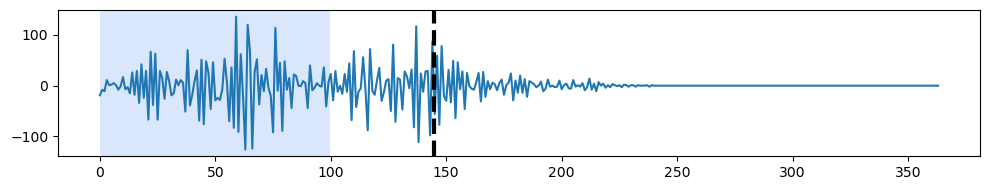

rbf
2


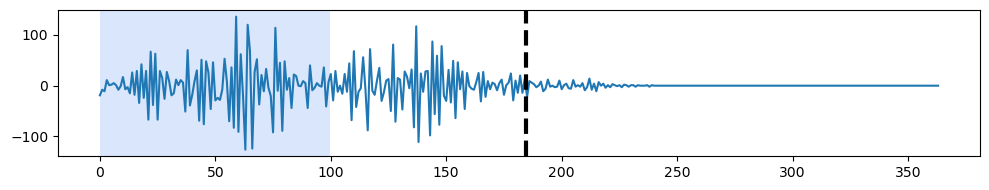

normal
2


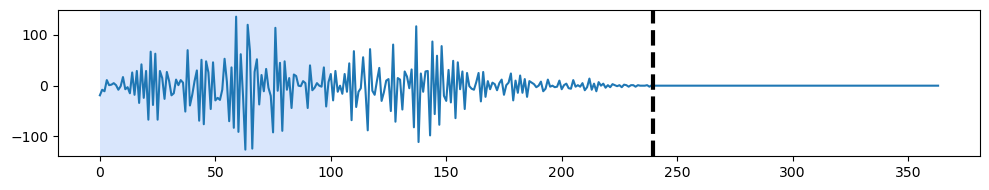

ar
2


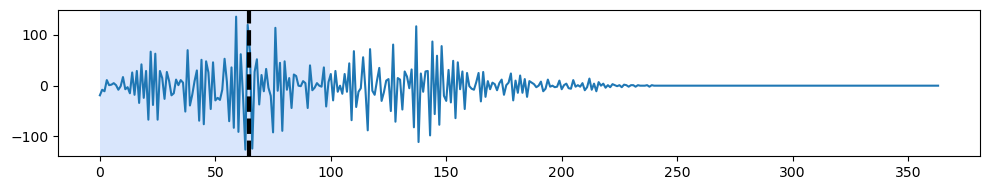

l2
3


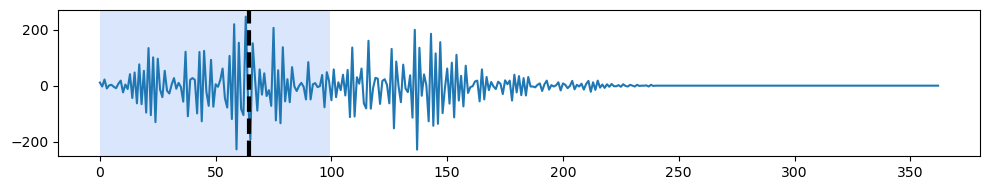

l1
3


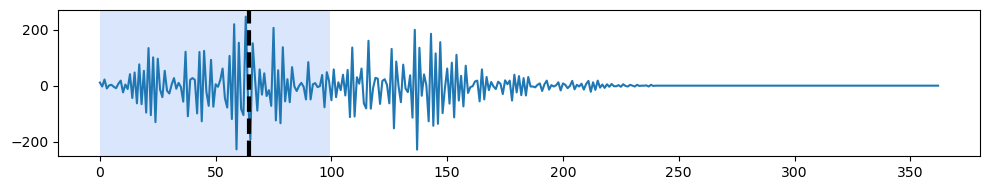

rbf
3


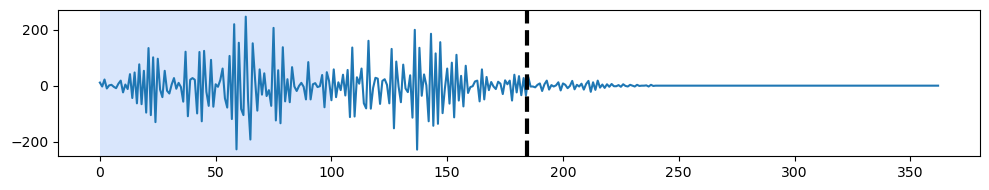

normal
3


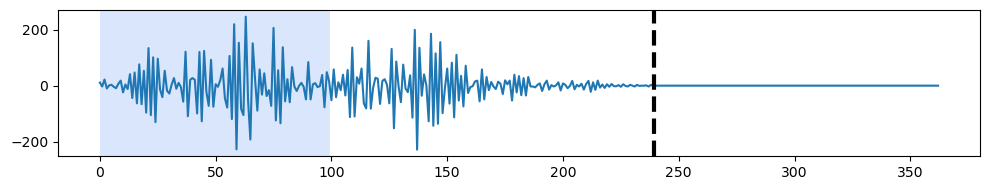

ar
3


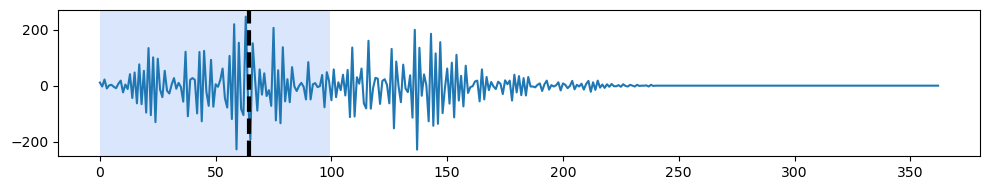

l2
4


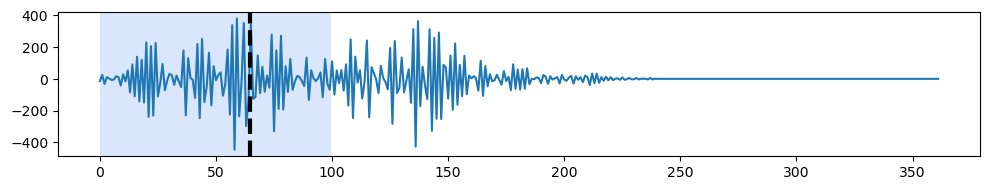

l1
4


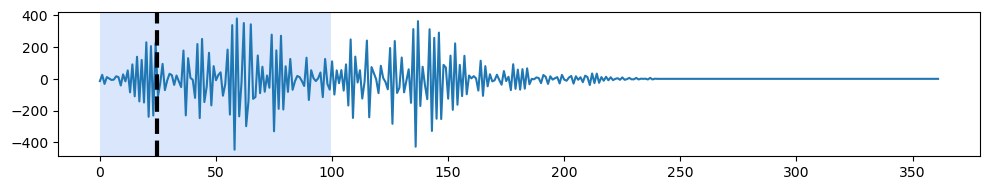

rbf
4


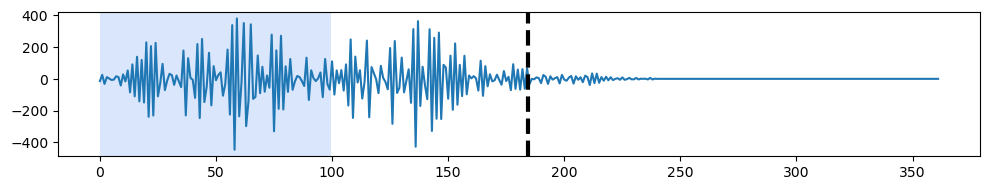

normal
4


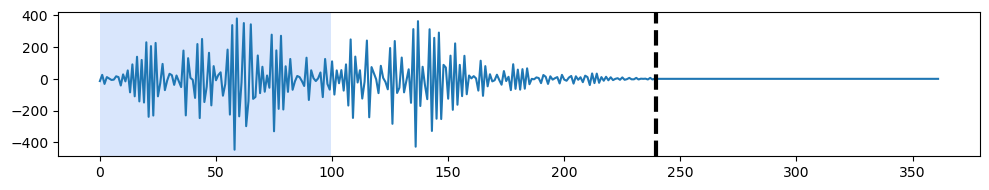

ar
4


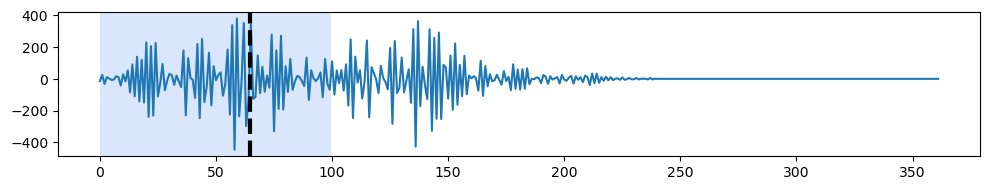

In [266]:
models = ["l2", "l1", "rbf", "normal", "ar"]

for n in range(5):
    for m in models:
        print(m)
        print(n)
        algo = rpt.BottomUp(model=m).fit(np.array(np.diff(data.i, n=n)))
        result = algo.predict(n_bkps=1)

        # display
        rpt.display(np.array(np.diff(data.i, n=n)), bkps, result)
        plt.show()

l2
0


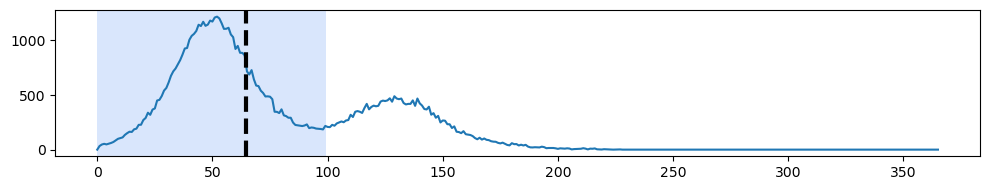

l1
0


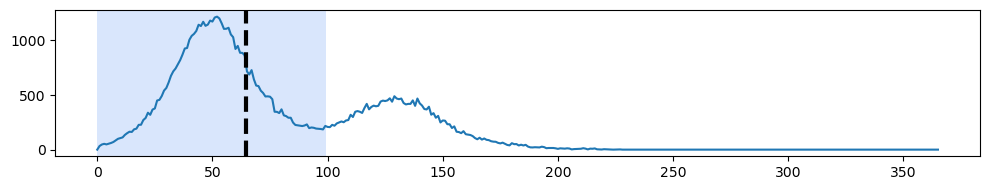

rbf
0


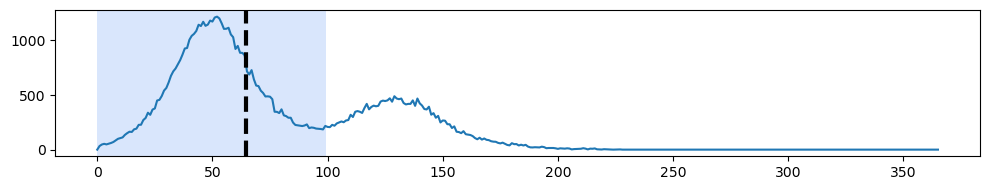

normal
0


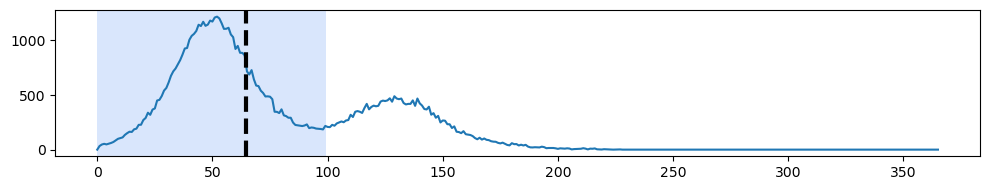

l2
1


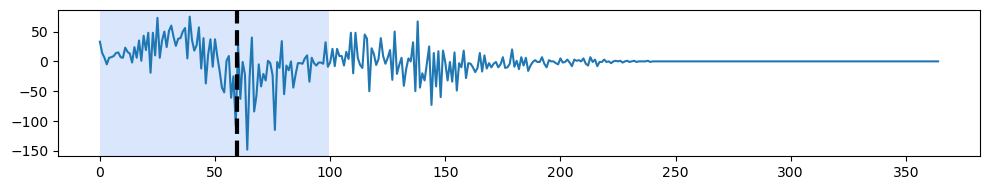

l1
1


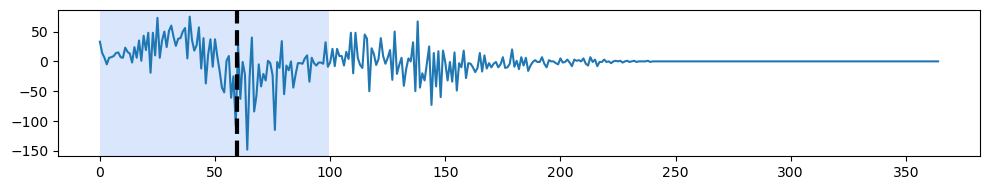

rbf
1


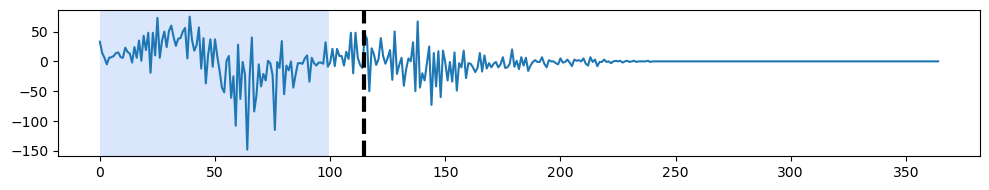

normal
1


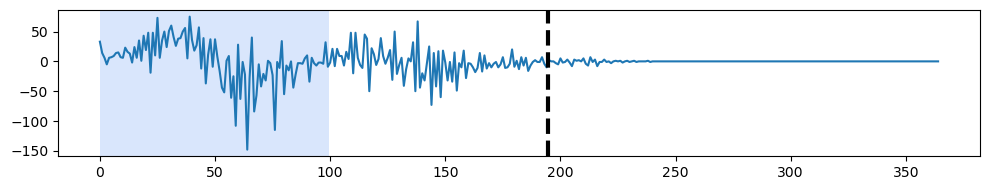

l2
2


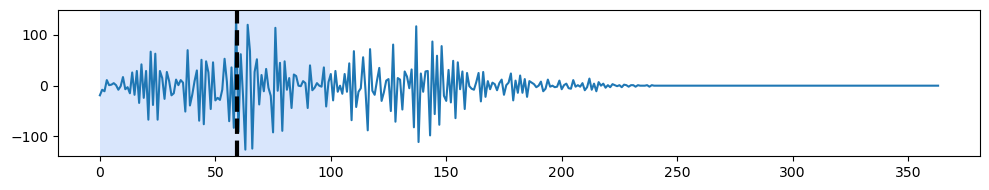

l1
2


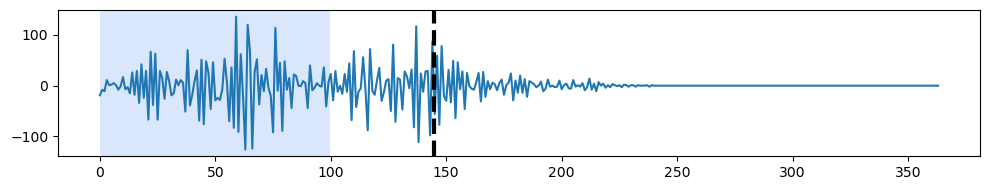

rbf
2


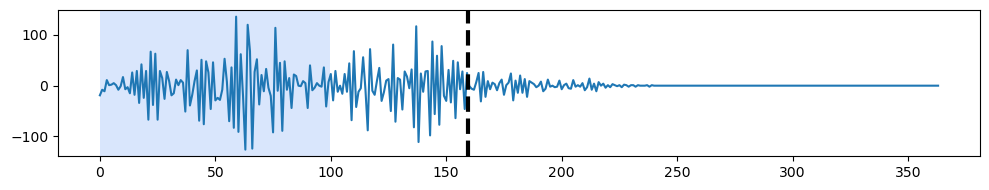

normal
2


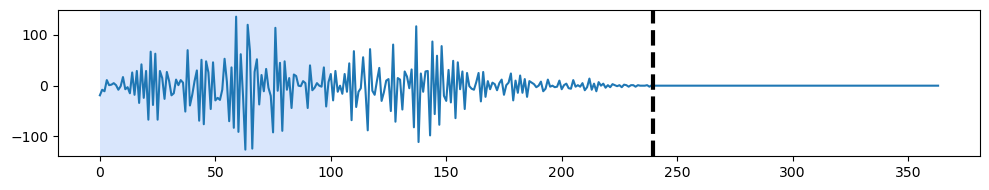

l2
3


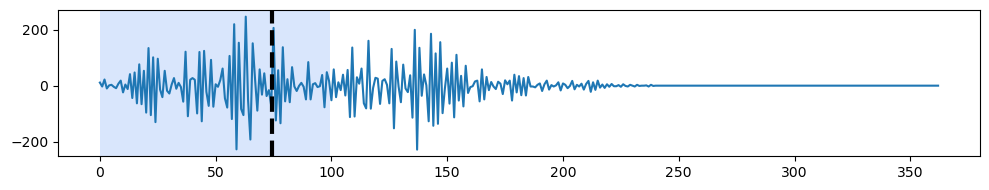

l1
3


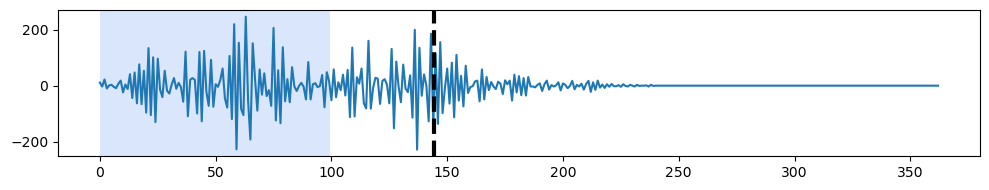

rbf
3


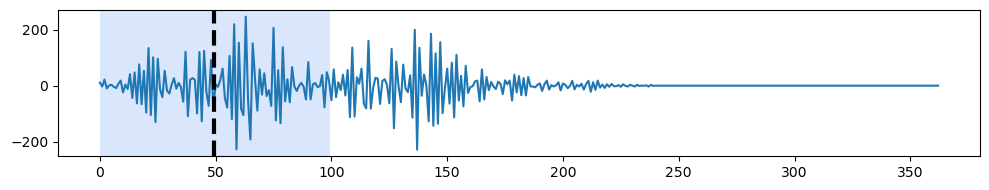

normal
3


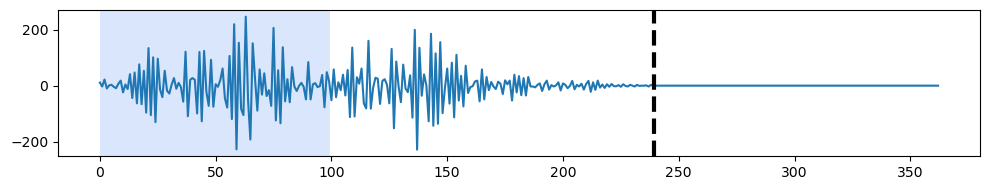

l2
4


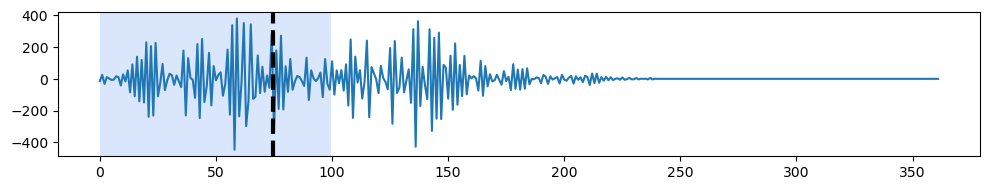

l1
4


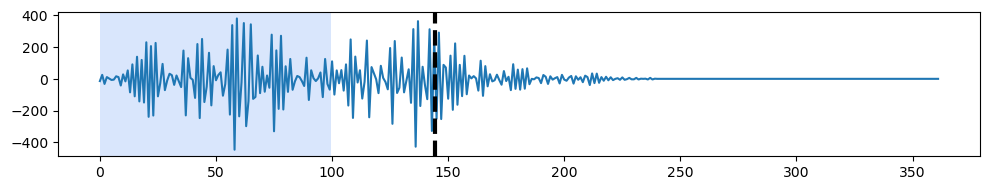

rbf
4


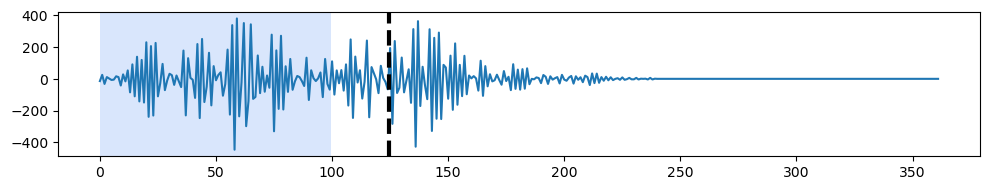

normal
4


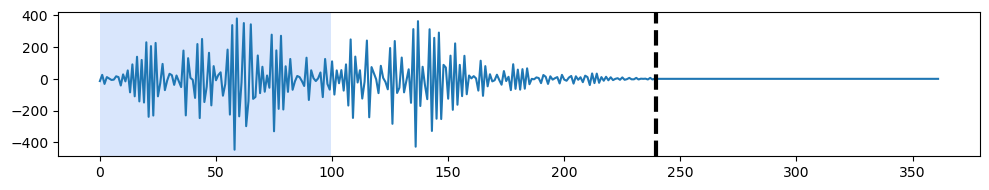

In [269]:
models = ["l2", "l1", "rbf", "normal"]

for n in range(5):
    for m in models:
        print(m)
        print(n)
        algo = rpt.Window(width=7, model=m).fit(np.array(np.diff(data.i, n=n)))
        result = algo.predict(n_bkps=1)

        # display
        rpt.display(np.array(np.diff(data.i, n=n)), bkps, result)
        plt.show()

## No time varying R

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff
import scipy.stats
import pymc as pm
import arviz as az
import sunode
import sunode.wrappers.as_aesara
import datetime
import shelve
from datetime import datetime as dt
import time
 
# -------- Usage --------#
# covid_obj = COVID_data('US', Population=328.2e6)
# covid_obj.get_dates(data_begin='7/11/20', data_end='7/20/20')
# sir_model = SIR_model(covid_obj)
# likelihood = {'distribution': 'lognormal', 'sigma': 2}
# prior= {'lam': 0.4, 'mu': 1/8, lambda_std', 0.5 'mu_std': 0.5 }
# sir_model.run_SIR_model(n_samples=20, n_tune=10, likelihood=likelihood)
np.random.seed(0)
 
class COVID_data():
 
    def __init__(self, country='US', Population = 328.2e6):
 
        confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
        self.confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
        deaths_url =  'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
        self.deaths = pd.read_csv(deaths_url, sep=',')
        path_to_save = ''
 
        # ------------------------- Country for inference -------------------
 
        self.country = country
        self.N = Population   # Population of the country
                         # Germany - 83.7e6
                         # US - 328.2e6
 
    def get_dates(self, data_begin='7/11/20', data_end='7/20/20'):
 
        # ------------------------- Date for inference ----------------------#
        self.data_begin = data_begin  #Take the data until yesterday
        self.data_end = data_end
        self.num_days_to_predict = 14
        confirmed_cases = self.confirmed_cases
        country = self.country
        self.cases_country = confirmed_cases.loc[confirmed_cases["Country/Region"] == country]
        self.cases_obs = np.array(confirmed_cases.loc[confirmed_cases["Country/Region"] == country, data_begin:data_end])[0]
 
        print("------------ Cases for selected period ----------- ",self.cases_obs)
 
        date_data_end = confirmed_cases.loc[confirmed_cases["Country/Region"] == self.country, data_begin:data_end].columns[-1]
        month, day, year = map(int,date_data_end.split('/'))
        date_data_end = datetime.date(year+2000, month, day)
        date_today = date_data_end + datetime.timedelta(days=1)
        print("------------- Cases yesterday ({}): {} and day before yesterday: {} ------------".format(date_data_end.isoformat(), *self.cases_obs[:-3:-1]))
        self.num_days = len(self.cases_obs)
 
        day_before_start = dt.strptime(data_end, '%m/%d/%y') + datetime.timedelta(days=-1)
        day_before_start_cases = np.array(self.cases_country.loc[:, day_before_start.strftime('%-m/%-d/%-y')])
        print("------------ Day before start and cases for that date ------------", day_before_start, day_before_start_cases)
        future_days_begin = dt.strptime(data_end, '%m/%d/%y') + datetime.timedelta(days=1)
        future_days_end = future_days_begin + datetime.timedelta(days=self.num_days_to_predict)
        self.future_days_begin_s = future_days_begin.strftime('%-m/%-d/%-y')
        self.future_days_end_s = future_days_end.strftime('%-m/%-d/%-y')
        print("------------- Future date begin and end -------------",self.future_days_begin_s, self.future_days_end_s)
        self.future_days = np.array(self.cases_country.loc[:, self.future_days_begin_s : self.future_days_end_s])[0]
        print("------------- Future days cases ------------", self.future_days)
 
 
class SIR_model():
 
    def __init__(self, covid_data) :
 
        # ------------------------- Covid_data object -----------------------#
        self.covid_data = covid_data
        # ------------------------- Setup SIR model, but has to be called explicitly to run ------------------------#
        self.setup_SIR_model()
 
    def SIR_non_normalized(self, y, t, p):
        ds = -p[0] * y[0] * y[1] /self.covid_data.N
        di = p[0] * y[0] * y[1] / self.covid_data.N  -  p[1] * y[1]
        return [ds, di]
 
    def setup_SIR_model(self):
        self.time_range = np.arange(0,len(self.covid_data.cases_obs),1)
        self.I0 = self.covid_data.cases_obs[0]
        self.S0 = self.covid_data.N - self.I0
 
        # SIR model
        self.sir_model_non_normalized = DifferentialEquation(
            func=self.SIR_non_normalized,
            times=self.time_range[1:],
            n_states=2,
            n_theta=2,
            t0=0) 
 
 
class SIR_model_sunode():
 
    def __init__(self, covid_data) :
 
        # ------------------------- Covid_data object -----------------------#
        self.covid_data = covid_data
        # ------------------------- Setup SIR model, but has to be called explicitly to run ------------------------#
        self.setup_SIR_model()
 
    def SIR_sunode(self, t, y, p):
        return {
            'S': -p.lam * y.S * y.I,
            'I': p.lam * y.S * y.I - p.mu * y.I,
        }
 
    def setup_SIR_model(self):
        self.time_range = np.arange(0,len(self.covid_data.cases_obs),1)
        self.I0 = self.covid_data.cases_obs[0]
        self.S0 = self.covid_data.N - self.I0
        self.S_init = self.S0 / self.covid_data.N
        self.I_init = self.I0 / self.covid_data.N
        self.cases_obs_scaled = self.covid_data.cases_obs / self.covid_data.N
 
 
    def run_SIR_model(self, n_samples, n_tune, likelihood, prior):
        # ------------------------- Metadata --------------------------------#
        now = dt.now()
        timenow = now.strftime("%d-%m-%Y_%H:%M:%S")
        self.filename = 'sir_' + self.covid_data.data_begin.replace('/','-') + '_' + \
            self.covid_data.data_end.replace('/','-') + '_' + timenow
        self.likelihood = likelihood
        self.n_samples = n_samples
        self.n_tune = n_tune
        self.likelihood = likelihood
        self.prior = prior
        # ------------------------ Write out metadata while the model is running -------------------#
        metadata_db_filename = 'metadata_db.db'
 
        t = time.time()
 
        with pm.Model() as model4:
            sigma = pm.HalfCauchy('sigma', self.likelihood['sigma'], shape=1)
            lam_mu = np.log(self.prior['lam']) + self.prior['lambda_std']**2
            mu_mu = np.log(self.prior['mu']) + self.prior['mu_std']**2
            lam = pm.Lognormal('lambda', lam_mu , self.prior['lambda_std']) # 1.5, 1.5
            mu = pm.Lognormal('mu', mu_mu, self.prior['mu_std'])           # 1.5, 1.5
 
            res, _, problem, solver, _, _ = sunode.wrappers.as_aesara.solve_ivp(
              y0={
              # The initial conditions of the ode. Each variable
              # needs to specify a theano or numpy variable and a shape.
              # This dict can be nested.
                  'S': (self.S_init, ()),
                  'I': (self.I_init, ()),},
              params={
              # Each parameter of the ode. sunode will only compute derivatives
              # with respect to theano variables. The shape needs to be specified
              # as well. It it infered automatically for numpy variables.
              # This dict can be nested.
                  'lam': (lam, ()),
                  'mu': (mu, ()),
                  '_dummy': (np.array(1.), ())},
              # A functions that computes the right-hand-side of the ode using
              # sympy variables.
              rhs=self.SIR_sunode,
              # The time points where we want to access the solution
              tvals=self.time_range,
              t0=self.time_range[0]
            )
            if(likelihood['distribution'] == 'lognormal'):
                I = pm.Lognormal('I', mu=res['I'], sigma=sigma, observed=self.cases_obs_scaled)
            elif(likelihood['distribution'] == 'normal'):
                I = pm.Normal('I', mu=res['I'], sigma=sigma, observed=self.cases_obs_scaled)
            elif(likelihood['distribution'] == 'students-t'):
                I = pm.StudentT( "I",  nu=likelihood['nu'],       # likelihood distribution of the data
                        mu=res['I'],     # likelihood distribution mean, these are the predictions from SIR
                        sigma=sigma,
                        observed=self.cases_obs_scaled
                        )
 
            print('Problem',problem)
            print('Solver',solver)
 
            R = 1 - (res['I'] + res['S'])
            R0 = pm.Deterministic('R0',lam/mu)

            step = pm.Metropolis()
            trace = pm.sample(self.n_samples, tune=self.n_tune, chains=4, cores=4)
            # data = az.from_pymc3(trace=trace)
 
        t1 = time.time() - t
        az.plot_posterior(trace, round_to=2, point_estimate='mode')
        axes = az.plot_trace(trace)
        fig = axes.ravel()[0].figure
        fig.savefig(self.filename)
        
        fig = ff.create_distplot([trace['R0']], bin_size=0.5, group_labels=['x'])
 
        # Add title
        fig.update_layout(title_text='Curve and Rug Plot')
        fig.update_xaxes(range=[0,7])
            
 
        self.metadata_db = shelve.open(metadata_db_filename)
        self.metadata_db[self.filename] = {'type': 'sir', 'samples': n_samples,
                                    'tune': n_tune,
                                    'elapsed_time': t1,
                                    'finished': dt.now().strftime("%d-%m-%Y_%H:%M:%S"),
                                    'likelihood': likelihood,
                                    'prior': prior }
        self.metadata_db.close()
        return(fig)
 
 
 
covid_obj = COVID_data('US', Population=328.2e6)
covid_obj.get_dates(data_begin='2/1/20', data_end='9/28/20')
sir_model = SIR_model_sunode(covid_obj)
likelihood = {'distribution': 'lognormal', 
              'sigma': 2}
prior = {'lam': 1.0, 
         'mu': 0.5, 
         'lambda_std': 1.0,
         'mu_std': 0.2 }
# fig1 = sir_model.run_SIR_model(n_samples=2000, n_tune=1000, likelihood=likelihood, prior=prior)
sir_model.run_SIR_model(n_samples=20, n_tune=1, likelihood=likelihood, prior=prior)

ModuleNotFoundError: ignored